# Lambda-Adaptive TD($\lambda$)
_
**Author:** Daniel Mastropietro  
**Date:** 19-Apr-2020
_

## Analysis of TD($\lambda$) and $\lambda$-return (here called MC($\lambda$)) on a 1D gridworld

A 1D gridworld with 21 states is considered, having the leftmost and rightmost states as terminal states giving respectively rewards -1.0 and +1.0 when attained.

The agent follows the random walk policy and its goal is to **estimate the state value function**.

Three different learners are considered:
- TD($\lambda$)
- $\lambda$-return (here called MC($\lambda$))
- $\lambda$-adaptive TD (new proposal), where $\lambda$ is allowed to vary at each time step, as a measure of the magnitude of the temporal gradient of the observed return.

**The goals of this exercise are:**  
1) Test an RL-framework that was created as a factory of policies and learners to be applied to different environments.  
2) To confirm that the implementation of the algorithms work on a very simple example.  
3) To get a feeling of the performance of an $\lambda$-adaptive TD algorithm.

### Environment setup

#### Modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm    # cm is for colormaps (e.g. cm.get_cmap())
from matplotlib import rc
rc('text', usetex=True)  # When usetex=True, mathematical symbols can be used in plots via Tex expressions enclosed in $..$

import runpy
runpy.run_path("../setup.py")

#from Python.lib import environments, agents
from Python.lib.environments import EnvironmentDiscrete
from Python.lib.agents import GeneralAgent

from Python.lib.environments import gridworlds
from Python.lib.agents.policies import random_walks
from Python.lib.agents.learners import mc
from Python.lib.agents.learners import td

from Python.lib.simulators import Simulator

%matplotlib inline

Directory:
E:\Daniel\Projects\PhD-RL-Toulouse\projects
has been prepended to the module search path.


#### Directories and names
Conventions about filenames:  
- Files containing datasets should use the underscore ('\_') as separator (so that when reading them into Python we could eventually create a data frame directly from its name)  
- All other files should use the hyphen ('-') as separator (e.g. images)

In [2]:
# Directory where results are saved (e.g. datasets)
g_dir_results = "./results"
# Subdirectory inside `the above directory where images are saved
g_dir_results_images = "202004Apr30-ResultsTDLambda&MC-1DGridworld"

# Prefix to use for the image filenames
g_prefix = "SimulateTDLambda-Gridworld1D"

### Auxiliary functions

In [12]:
def parse_info_type(info_type):
    return "AlphasByEpisodeLastExp" if info_type == "alphas" else "RMSEByEpisode"

def save(df, version, method, info_type, params, lmbda, alpha, prefix="SimulateTDLambda"):
    """
    Saves a data frame to a file whose name is specified by a set of `params`.
    
    The information is of type `info_type` and was obtained using `method` as learning algorithm.
    """

    info_type = parse_info_type(info_type)
    filename = "{}/{}_v{}_{}_{}_l={:.2f},a={:.2f},adj={},adjbyepi={},amin={}_Epi{}_Exp{}.csv" \
                .format(g_dir_results, prefix, version, method, info_type,
                        lmbda, alpha,
                        params['adjust_alpha'], params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments'])

    try:
        print("Saving data frame to file {}...".format(filename))
        df.to_csv(filename, index=False)
    except IOError as e:
        print("The file could not be created: {}".format(filename))
#        print(e.strerror)
        pass

    return df

def load(version, method, info_type, params, lmbda, alpha, prefix="SimulateTDLambda"):
    """
    Reads a data frame to a file whose name is specified by a set of `params`.
    
    The information is of type `info_type` and was obtained using `method` as learning algorithm.
    """

    info_type = parse_info_type(info_type)
    filename = "{}/{}_v{}_{}_{}_l={:.2f},a={:.2f},adj={},adjbyepi={},amin={}_Epi{}_Exp{}.csv" \
                .format(g_dir_results, prefix, version, method, info_type,
                        lmbda, alpha,
                        params['adjust_alpha'], params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments'])

    df = None
    try:
        print("Reading data into data frame from file {}...".format(filename))
        df = pd.read_csv(filename)
    except IOError as e:
        print("The file could not be read: {}".format(filename))
#        print(e.strerror)
        pass

    return df

### Plotting functions


In [4]:
def plot_rmse_by_episode(rmse_mean_values, rmse_se_values=None, max_rmse=None, color="black",
                         alphas=None, alpha_min=0.0, marker_alphas='k:', max_alpha=None, hold=False, subtitle="", fontsize=12, legend=True):
    """
    Plots the average RMSE values (over states) by episode
    
    @param rmse_mean_values: numpy array containing the average RMSE value per episode.
    @param rmse_se_values: (optional) numpy array containing an error measure of the average RMSE, e.g. their standard error.
    @param max_mse: (optional) maximum RMSE value to show in the plot (for visual comparison reasons)
    """
    
    def finalize_plot_rmse(axis, xlabel="Episode", ylabel="RMSE", legend="RMSE"):
        if rmse_se_values is not None:
            axis.errorbar(time, rmse_mean_values, yerr=rmse_se_values, capsize=4, color=color)
        #axis.set_xticks(np.arange(nepisodes)+1)
        axis.tick_params(axis='both', which='major', labelsize=np.round(fontsize*0.8))
        axis.set_ylim((0, max_rmse))
        axis.set_xlabel(xlabel, fontsize=fontsize)
        axis.set_ylabel(ylabel, fontsize=fontsize)    
        axis.set_title("Average RMSE by episode {}".format(subtitle), fontsize=fontsize)
        axis.legend([legend], loc='upper left', fontsize=fontsize)

    def finalize_plot_alpha(axis, ylabel="Average alpha in last experiment", legend=r"Average $\alpha$ over states visited in episode"):
        axis.tick_params(axis='both', which='major', labelsize=np.round(fontsize*0.8))
        axis.axhline(y=alpha_min, color='gray')
        axis.set_ylabel(ylabel, fontsize=fontsize)
        if max_alpha is not None:
            # We use a positive value for the minimum alpha so that the log transform does not complain
            # when changing the axis to log scale.
            axis.set_ylim((1E-6, max_alpha))
        axis.legend([legend], loc='upper right', fontsize=fontsize)

    # X-axis (time)
    nepisodes = len(rmse_mean_values)
    time = np.arange(nepisodes)+1

    if max_rmse is None:
        max_rmse = np.max(rmse_mean_values)*1.1

    if not hold:
        fig = plt.figure(figsize=(20,10))
        (ax, ax_tlog) = fig.subplots(1,2)

    ax.plot(time, rmse_mean_values, color=color, linewidth=2, zorder=10)
        ## zorder is used to define layer order (larger values imply going on top)
        ## Ref: stackoverflow.com/questions/37246941/specifying-the-order-of-matplotlib-layers
    finalize_plot_rmse(ax)

    ax_tlog.plot(time, rmse_mean_values, color=color, linewidth=2, zorder=10)
    # IMPORTANT: We first need to transform the axis to log scale BEFORE applying the axis limits in finalize_plot_rmse()
    # because otherwise the log-scale transformation screws up the plot and doesn't show anything... the reason is that
    # the aforementioned function sets the axis minimum value to 0. Note that I don't want to set it to a very small
    # positive number because if I do so we don't really see much what's going on in the graph.
    ax_tlog.set_xscale('log')
    ax_tlog.set_yscale('log')
    finalize_plot_rmse(ax_tlog, xlabel="Episode (log scale)", ylabel="RMSE (log scale)")

    if alphas is not None:
        ax2 = ax.twinx()
        ax2.plot(time, alphas, marker_alphas, zorder=0)
        finalize_plot_alpha(ax2)

        ax2_tlog = ax_tlog.twinx()
        ax2_tlog.plot(time, alphas, marker_alphas, zorder=0)
        finalize_plot_alpha(ax2_tlog)
        ax2_tlog.set_xscale('log')
        ax2_tlog.set_yscale('log')

        # Go back to the primary axis of the left subplot
        plt.sca(ax)

        return ax, ax_tlog, ax2, ax2_tlog
    else:
        return ax, ax_tlog

### Simulation functions

In [5]:
def simulate(env, policy, learner,
             seed=None, nexperiments=10, nepisodes=20, start=None,
             alphas=[0.2], lambdas=[0.9], gamma=0.8,
             adjust_alpha=False, adjust_alpha_by_episode=True, alpha_min=0.,
             lambda_min=0., burnin=False,  # Parameters used in the adaptive TD lambda
             plot=True, max_alpha=1, max_rmse=0.5, error_bars=True,
             verbose=True, verbose_period=100, debug=False, show_warnings=True):
    """
    Simulates an environment using the given policy and learner
    
    Returns:
        A tuple containing the following elements:
        - A pandas data frame containing the average RMSE over all experiments run
        for each alpha and lambda combination run in the simulations.
        - A pandas data frame containing:
            - the episode number (starting at 1)
            - the average RMSE over all states averaged over all experiments run
            on all alpha and lambda combinations considered in the simulation.
            - the standard error of the above said average RMSE.
        - A dictionary containing state information as follows:
            - the average number of visits over all experiments run on the simulation
            with the largest alpha and largest lambda considered.
            - the value of the learning rate alpha for each state at the end of
            the episode for the last experiment run on the largest alpha and largest lambda
            considered.
    """

    # Remove overflow warnings that happen when lambda and/or alpha are too large...    
    import warnings
    if show_warnings:
        warnings.filterwarnings("once")
    else:
        warnings.filterwarnings("ignore")

    learner_module = learner.__module__.upper()
    learner_name = learner_module[ learner_module.rfind(".")+1:]

    # Plotting setup
    if plot:
        colormap = cm.get_cmap("jet")
        fig = plt.figure(figsize=(20, 10))
        #(ax_full, ax_scaled, ax_rmse_by_episode) = fig.subplots(1,3)
        (ax_full, ax_scaled) = fig.subplots(1,2)

    n_lambdas = len(lambdas)
    n_alphas = len(alphas)
    n_simul = n_lambdas*n_alphas

    # List of dictionaries, each containing the characteristic of each parameterization considered
    df_results = pd.DataFrame(data=np.nan*np.zeros((n_simul, 5)), columns=['idx_lambda', 'lambda', 'alpha', 'rmse_mean', 'rmse_se'])
    legend_label = []
    # Average RMSE obtained at the LAST episode run for each parameter set and their standard error
    rmse_mean_values = np.nan*np.zeros((n_lambdas, n_alphas))
    rmse_se_values = np.nan*np.zeros((n_lambdas, n_alphas))
    # Average RMSE over the episodes run for each parameter set and their standard error 
    rmse_episodes_mean = np.nan*np.zeros((n_lambdas, n_alphas))
    rmse_episodes_se = np.nan*np.zeros((n_lambdas, n_alphas))
    # RMSE over the episodes averaged over ALL parameter set runs with their standard error
    rmse_episodes_mean_values = np.zeros(nepisodes)
    rmse_episodes_se2_values = np.zeros(nepisodes)
    idx_simul = -1
    for idx_lmbda, lmbda in enumerate(lambdas):
        rmse_mean_lambda = []
        rmse_se_lambda = []
        rmse_episodes_mean_lambda = []
        rmse_episodes_se_lambda = []
        for alpha in alphas:
            idx_simul += 1
            if verbose:
                print("Parameter set {} of {}: lambda = {:.2f}, alpha = {:.2f} --->" \
                      .format(idx_simul+1, n_simul, lmbda, alpha), end=" ")
            if isinstance(learner, td.LeaTDLambdaAdaptive):
                learner.setParams(alpha=alpha, gamma=gamma, lmbda=lmbda, adjust_alpha=adjust_alpha, adjust_alpha_by_episode=adjust_alpha_by_episode, alpha_min=alpha_min, lambda_min=lambda_min, burnin=burnin)
            else:
                learner.setParams(alpha=alpha, gamma=gamma, lmbda=lmbda, adjust_alpha=adjust_alpha, adjust_alpha_by_episode=adjust_alpha_by_episode, alpha_min=alpha_min)
            learner.reset(reset_episode=True, reset_value_functions=True)
            agent = GeneralAgent(pol_rw,
                                 learner)
            # NOTE: Setting the seed here implies that each set of experiments
            # (i.e. for each combination of alpha and lambda) yields the same outcome in terms
            # of visited states and actions.
            # This is DESIRED --as opposed of having different state-action outcomes for different
            # (alpha, lambda) settings-- as it better isolates the effect of alpha and lambda.
            # VERIFIED BY RUNNING IN DEBUG MODE!
            sim = Simulator(env, agent, seed=seed, debug=debug)

            # Run the simulation and store the results
            N_mean, rmse_mean, rmse_se, rmse_episodes_mean_idx, rmse_episodes_se_idx, learning_info = \
                                                sim.simulate(nexperiments=nexperiments,
                                                             nepisodes=nepisodes,
                                                             start=start,
                                                             verbose=verbose, verbose_period=verbose_period)
            df_results.loc[idx_simul] = [idx_lmbda, lmbda, alpha, rmse_mean, rmse_se]
            rmse_mean_lambda += [rmse_mean]
            rmse_se_lambda += [rmse_se]
            # Average RMSE over all the episodes (this is what is reported by Sutton in their graphs in Chapter 12)
            # (not the best measure to report according to me... we should just look at the RMSE once the LAST episode is run
            # since the agent learns more after every episode!)
            rmse_episodes_mean_lambda += [np.mean(rmse_episodes_mean_idx)]
            rmse_episodes_se_lambda += [np.std(rmse_episodes_mean_idx) / np.sqrt(nepisodes)]
            # Average RMSE by episode and their standard error
            rmse_episodes_mean_values += rmse_episodes_mean_idx
            rmse_episodes_se2_values += rmse_episodes_se_idx**2

            if verbose:
                print("\tRMSE = {:.3g} ({:.3g})".format(rmse_mean, rmse_se))

        # Store the RMSE results for the current lambda
        rmse_mean_values[idx_lmbda] = np.array(rmse_mean_lambda)
        rmse_se_values[idx_lmbda] = np.array(rmse_se_lambda)
        rmse_episodes_mean[idx_lmbda] = np.array(rmse_episodes_mean_lambda)
        rmse_episodes_se[idx_lmbda] = np.array(rmse_episodes_se_lambda)

        if plot:
            # Plot the average RMSE for the current lambda as a function of alpha
            #rmse2plot = rmse_mean_lambda
            #rmse2plot_error = rmse_se_lambda
            #ylabel = "Average RMSE over all {} states, at the end of episode {}, averaged over {} experiments".format(env.getNumStates(), nepisodes, nexperiments)
            rmse2plot = rmse_episodes_mean_lambda
            rmse2plot_error = rmse_episodes_se_lambda
            ylabel = "Average RMSE over all {} states, first {} episodes, and {} experiments".format(env.getNumStates(), nepisodes, nexperiments)

            # Map blue to the largest lambda and red to the smallest lambda (most similar to the color scheme used in Sutton, pag. 295)
            color = colormap( 1 - idx_lmbda / np.max((1, n_lambdas-1)) )
            ax_full.plot(alphas, rmse2plot, '.-', color=color)
            if error_bars:
                ax_full.errorbar(alphas, rmse2plot, yerr=rmse2plot_error, capsize=4, color=color)
            ax_full.set_title("Error measure for different (lambda, alpha) (FULL scale)")
            ax_full.set_xlabel("alpha")
            ax_full.set_ylabel(ylabel)
            legend_label += ["lam={:.2g}".format(lmbda)]

    # Average RMSE by episode for rate of convergence analysis
    rmse_episodes_mean_overall = rmse_episodes_mean_values / n_simul
    rmse_episodes_se_overall = np.sqrt(rmse_episodes_se2_values) / n_simul  # This is sqrt( sum(SE^2) ) / n_simul, based on calculations done on paper on 19-Apr-2020

    # Scaled plot (for comparison purposes)
    if plot:
        for idx_lmbda, lmbda in enumerate(lambdas):
            #rmse2plot = rmse_mean_values[idx_lmbda]
            #rmse2plot_error = rmse_se_values[idx_lmbda]
            rmse2plot = rmse_episodes_mean[idx_lmbda]
            rmse2plot_error = rmse_episodes_se[idx_lmbda]
            color = colormap( 1 - idx_lmbda / np.max((1, n_lambdas-1)) )
            ax_scaled.plot(alphas, rmse2plot, '.-', color=color)
            if error_bars:
                ax_scaled.errorbar(alphas, rmse2plot, yerr=rmse2plot_error, capsize=4, color=color)
            ax_scaled.set_title("Error measure for different (lambda, alpha) (ZOOMED for visual comparison)")
            ax_scaled.set_xlabel("alpha")
            ax_scaled.set_xlim((0, max_alpha))
            ax_scaled.set_ylim((0, max_rmse))

        plt.figlegend(legend_label)
        fig.suptitle("{}(lambda): gamma = {:.2g}, No. experiments = {}, No. episodes = {}"\
                     .format(learner_name, gamma, nexperiments, nepisodes), fontsize=18)

    # Restore warnings default
    warnings.filterwarnings("default")

    # Store the state information for the last simulation run
    # TODO: Store the state information for EACH alpha-lambda combination run
    state_info = {'nvisits': N_mean,
                  'alphas_by_episode':  learning_info['alphas_by_episode'],
                  'alphas_at_episode_end': learning_info['alphas_at_episode_end'],
                 }

    return  df_results, \
            pd.DataFrame({'episode': np.arange(nepisodes) + 1, 'rmse_mean': rmse_episodes_mean_overall, 'rmse_se': rmse_episodes_se_overall}), \
            state_info

In [6]:
# The environment
env = gridworlds.EnvGridworld1D(length=21)

# Possible policies and learners for agents
pol_rw = random_walks.PolRandomWalkDiscrete(env)
lea_td = td.LeaTDLambda(env)
lea_td_adap = td.LeaTDLambdaAdaptive(env)
lea_mc = mc.LeaMCLambda(env)

#-- Define hyperparameter values
gamma = 1  # Undiscounted task, as stated in Example 6.2, Sutton, pag. 125 when they present the 5-step 1D random walk extended later on to 19-step random walk
# Grid values
n_lambdas = 10
n_alphas = 8
lambdas_grid = np.linspace(0, 1, n_lambdas)
alphas_grid = np.linspace(0.1, 0.7, n_alphas)
# Ad-hoc values
lambdas_adhoc_mc = [0, 0.4, 0.8, 0.9, 0.95, 0.99, 1]
alphas_adhoc_mc = [0.01] + list(np.linspace(0.1, 1.2, 10))
lambdas_adhoc_td = [0, 0.4, 0.8, 0.9, 0.95, 0.99, 1]
alphas_adhoc_td = [0.01] + list(np.linspace(0.1, 0.9, 10))

### 1) TD($\lambda$), $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes

    idx_lambda  lambda     alpha      rmse_mean  rmse_se
0          0.0    0.00  0.010000   5.133417e-01      NaN
1          0.0    0.00  0.100000   4.534869e-01      NaN
2          0.0    0.00  0.188889   4.020020e-01      NaN
3          0.0    0.00  0.277778   3.551558e-01      NaN
4          0.0    0.00  0.366667   3.124732e-01      NaN
5          0.0    0.00  0.455556   2.740783e-01      NaN
6          0.0    0.00  0.544444   2.407044e-01      NaN
7          0.0    0.00  0.633333   2.138176e-01      NaN
8          0.0    0.00  0.722222   1.956813e-01      NaN
9          0.0    0.00  0.811111   1.891569e-01      NaN
10         0.0    0.00  0.900000   1.971828e-01      NaN
11         1.0    0.40  0.010000   5.087657e-01      NaN
12         1.0    0.40  0.100000   4.128227e-01      NaN
13         1.0    0.40  0.188889   3.326220e-01      NaN
14         1.0    0.40  0.277778   2.620902e-01      NaN
15         1.0    0.40  0.366667   2.007087e-01      NaN
16         1.0    0.40  0.45555

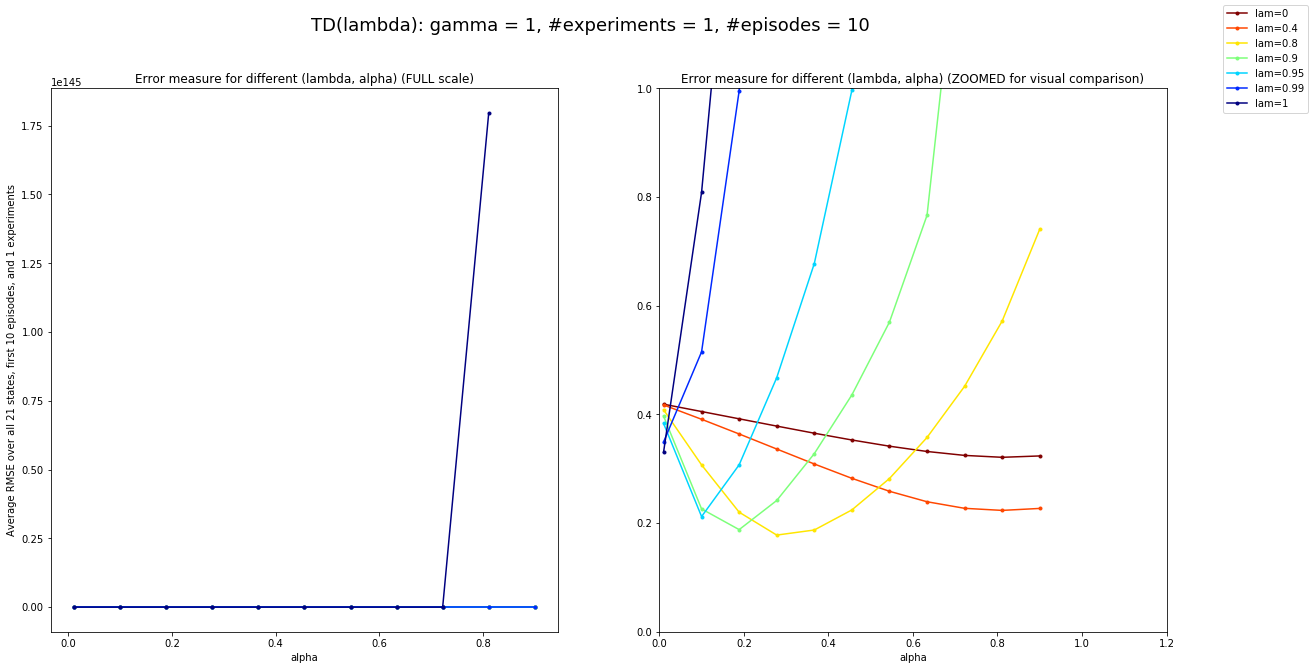

In [5]:
# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_td, df_rmse_by_episode_td, state_info_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_td, lambdas=lambdas_adhoc_td, gamma=gamma, adjust_alpha=False,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_td)

The RMSE diverges very "quickly" for smaller and smaller $\alpha$'s as $\lambda$ gets larger.

### 2) MC($\lambda$), $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes

    idx_lambda  lambda     alpha  rmse_mean  rmse_se
0          0.0    0.00  0.010000   0.512948      NaN
1          0.0    0.00  0.100000   0.451342      NaN
2          0.0    0.00  0.222222   0.381735      NaN
3          0.0    0.00  0.344444   0.318881      NaN
4          0.0    0.00  0.466667   0.263981      NaN
5          0.0    0.00  0.588889   0.222098      NaN
6          0.0    0.00  0.711111   0.200624      NaN
7          0.0    0.00  0.833333   0.211526      NaN
8          0.0    0.00  0.955556   0.259476      NaN
9          0.0    0.00  1.077778   0.336443      NaN
10         0.0    0.00  1.200000   0.440339      NaN
11         1.0    0.40  0.010000   0.508160      NaN
12         1.0    0.40  0.100000   0.409809      NaN
13         1.0    0.40  0.222222   0.304258      NaN
14         1.0    0.40  0.344444   0.219607      NaN
15         1.0    0.40  0.466667   0.159410      NaN
16         1.0    0.40  0.588889   0.131980      NaN
17         1.0    0.40  0.711111   0.139088   

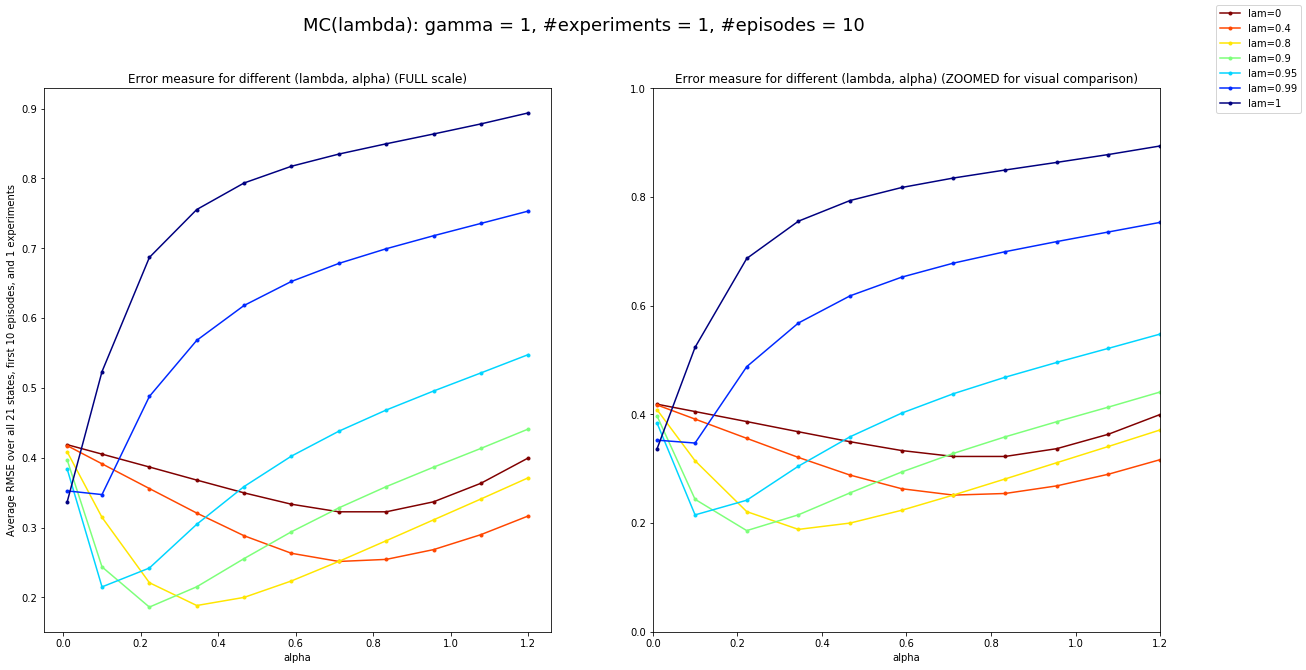

In [170]:
# Simulation setup
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_mc, df_rmse_by_episode_mc, state_info_mc = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_mc, lambdas=lambdas_adhoc_mc, gamma=gamma, adjust_alpha=False,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_mc)

The RMSE diverges much more slowly than the TD case as $\alpha$ increases beyond the optimum attained for each $\lambda$.

### 3) $\lambda$-adaptive TD, $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes
This algorithm proposes to adapt $\lambda$ at each learning time step in the TD($\lambda$) algorithm by defining $\lambda$ as a function of the $\delta(t)$ TD error, i.e.:

$\delta(t) = R_{t+1} + \gamma V(S(t+1)) - V(S(t))$

where $V(s)$ is the estimated state value function for state $s$, and $S(t)$ is the state of the environment at time $t$.

The value of $\lambda$ is now allowed to change at each time step $t$ and is proposed as a sigmoid function of the $\delta(t)$ error *relative* to the estimated state value function at time $t$, namely:

$\lambda(t) = 1 - exp(- |\delta_{rel}(t)| )$

where $\delta_{rel}(t)$ is given by:

- $0$ if $V(S(t)) = 0$ and $\delta(t) = 0$
- $+\infty$ if $V(S(t)) = 0$ and $\delta(t) \neq 0$
- $\frac{\delta(t)}{V(S(t))}$ o.w.

Note that $\lambda(t) \to 0^+$ when $\delta_{rel}(t) \to 0$ and $\lambda(t) \to 1^-$ when $|\delta_{rel}(t)| \to +\infty$.

However, this adaptation is _not_ done for all time steps: in order to _accelerate_ the initial convergence of the algorithm for environments with terminal-only rewards, we use a fixed $\lambda$ for a time step as long as the _value function at the next time step has not been updated at least once_.

    idx_lambda  lambda     alpha  rmse_mean  rmse_se
0          0.0    0.00  0.010000   0.506263      NaN
1          0.0    0.00  0.100000   0.382753      NaN
2          0.0    0.00  0.188889   0.290652      NaN
3          0.0    0.00  0.277778   0.218444      NaN
4          0.0    0.00  0.366667   0.158324      NaN
5          0.0    0.00  0.455556   0.108724      NaN
6          0.0    0.00  0.544444   0.074337      NaN
7          0.0    0.00  0.633333   0.070477      NaN
8          0.0    0.00  0.722222   0.098030      NaN
9          0.0    0.00  0.811111   0.143190      NaN
10         0.0    0.00  0.900000   0.192044      NaN
11         1.0    0.40  0.010000   0.506263      NaN
12         1.0    0.40  0.100000   0.382753      NaN
13         1.0    0.40  0.188889   0.290652      NaN
14         1.0    0.40  0.277778   0.218444      NaN
15         1.0    0.40  0.366667   0.158324      NaN
16         1.0    0.40  0.455556   0.108724      NaN
17         1.0    0.40  0.544444   0.074337   

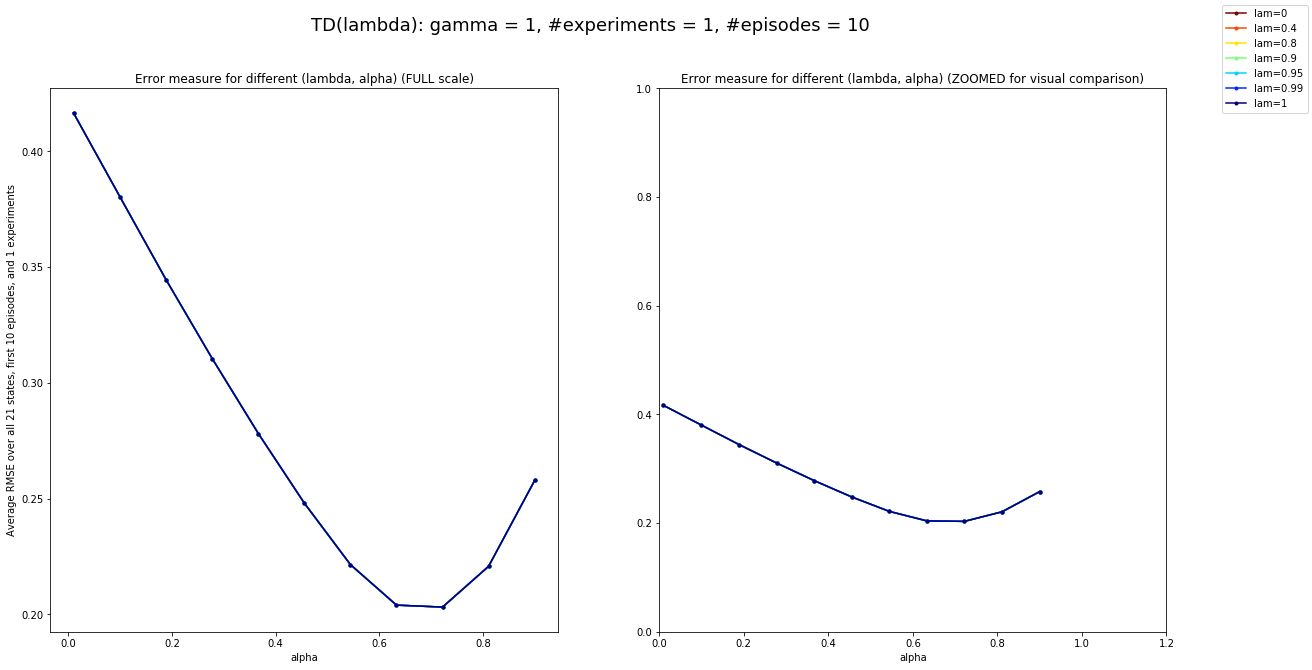

In [5]:
from importlib import reload
from Python.lib.agents.learners import td
reload(td)
from Python.lib.agents.learners import td
from Python.lib.agents.learners.td import LeaTDLambdaAdaptive
##from td import LeaTDLambdaAdaptive    # <-- Here I get the error that no module named 'td' exists... WHY??? (since reload(td) gives no error!!)

# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10

# Parameters specific to the adaptive case
lambda_min = 0.
burnin = False

df_results_td, df_rmse_by_episodes_td_adap, state_info_adap_td = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_td, lambdas=lambdas_adhoc_td, gamma=gamma, adjust_alpha=False,
                         lambda_min=lambda_min, burnin=burnin,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_td)

In this case there is clearly **only one curve** since $\lambda$ is no longer a hyperparameter of the optimization problem.

### 4) Analysis of the rate of convergence
We now compare the evolution of the average RMSE (over all states and all experiments) among the three algorithms.

For each algorithm we choose the $\lambda$ and $\alpha$ parameters that correspond to the minimum RMSE from the above simulations, namely:

- TD($\lambda$): $\lambda = 0.8$, $\alpha = 0.3$  
- MC($\lambda$): $\lambda = 0.8$, $\alpha = 0.35$
- TD adaptive: $\alpha = 0.65$

We run 30 experiments with 10 episodes each.

In [21]:
# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10
#-- Optimum parameters for TD(lambda) and MC(lambda)
# Based on profile analysis WITHOUT adjusting alpha
# For TD(adaptive) we use the same parameters as TD(lambda) (although according to the adpative TD(lambda) plot, the best combination is lambda=0.9, alpha=0.38)
lambdas_opt = {'td': 0.8, 'mc': 0.8, 'td_adap': 0.8}
alphas_opt = {'td': 0.3, 'mc': 0.35, 'td_adap': 0.7}
# Based on profile analysis ADJUSTING alpha
#lambdas_opt = {'td': 0.9, 'mc': 0.9, 'td_adap': 0.95}
#alphas_opt = {'td': 0.2, 'mc': 1.2, 'td_adap': 0.38}
# Extreme cases
lambdas_opt = {'td': 0., 'mc': 1, 'td_adap': 0.}
alphas_opt = {'td': 0.8, 'mc': 0.1, 'td_adap': 0.7}
#lambdas_opt = {'td': 1, 'mc': 1, 'td_adap': 0.}
#alphas_opt = {'td': 0.01, 'mc': 0.1, 'td_adap': 0.7}

adjust_alpha = True
adjust_alpha_by_episode = True
alpha_min = 0.001
lambda_min = 0.1
burnin = False

version = "0.7"
fontsize = 14

In [22]:
# TD(lambda)
df_results_td, df_rmse_by_episode_td_epi10, state_info_td_epi10 = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td']], lambdas=[lambdas_opt['td']], gamma=gamma,
                         adjust_alpha=adjust_alpha, adjust_alpha_by_episode=adjust_alpha_by_episode, alpha_min=0.0,
                         plot=False, verbose=True, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda)")
print(df_rmse_by_episode_td_epi10)
print(state_info_td_epi10)

Parameter set 1 of 1: lambda = 0.00, alpha = 0.80 ---> Running experiment 1 of 1 (#episodes = 10)... Value function at start of experiment: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Episode 1 of 10 running...
	RMSE(at end of experiment) = 0.189
	RMSE = 0.189 (nan)
RMSE by Episode for TD(lambda)
   episode  rmse_mean  rmse_se
0        1   0.483046      NaN
1        2   0.450885      NaN
2        3   0.406451      NaN
3        4   0.367650      NaN
4        5   0.336039      NaN
5        6   0.301130      NaN
6        7   0.278328      NaN
7        8   0.256635      NaN
8        9   0.207142      NaN
9       10   0.189235      NaN
{'nvisits': array([ 0., 11., 19., 25., 33., 47., 52., 56., 73., 89., 89., 74., 76.,
       84., 77., 64., 42., 25., 17., 10.,  0.]), 'alphas_by_episode': [0.7999999999999998, 0.7999999999999998, 0.7999999999999999, 0.7999999999999998, 0.7999999999999998, 0.8000000000000002, 0.8, 0.8000000000000002, 0.7999999999999998, 0.3999999999999999],

In [6]:
# lambda-return
df_results_mc, df_rmse_by_episode_mc_epi10, state_info_mc_epi10 = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['mc']], lambdas=[lambdas_opt['mc']], gamma=gamma,
                         adjust_alpha=adjust_alpha, adjust_alpha_by_episode=adjust_alpha_by_episode, alpha_min=alpha_min,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for MC(lambda)")
print(df_rmse_by_episode_mc_epi10)
print(state_info_mc_epi10)

RMSE by Episode for MC(lambda)
   episode  rmse_mean  rmse_se
0        1   0.358691      NaN
1        2   0.438462      NaN
2        3   0.393461      NaN
3        4   0.372888      NaN
4        5   0.417053      NaN
5        6   0.409602      NaN
6        7   0.377249      NaN
7        8   0.376288      NaN
8        9   0.377674      NaN
9       10   0.355778      NaN


In [9]:
# Adaptive TD(lambda)
df_results_td_adap, df_rmse_by_episode_td_adap_epi10, state_info_td_adap_epi10  = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td_adap']], lambdas=[lambdas_opt['td_adap']], gamma=gamma,
                         adjust_alpha=adjust_alpha, adjust_alpha_by_episode=adjust_alpha_by_episode, alpha_min=0.0,
                         lambda_min=lambda_min, burnin=burnin,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda) adaptive")
print(df_rmse_by_episode_td_adap_epi10)
print(state_info_td_adap_epi10)

RMSE by Episode for TD(lambda) adaptive
   episode  rmse_mean   rmse_se
0        1   0.399929  0.001509
1        2   0.337480  0.007884
2        3   0.293154  0.008548
3        4   0.241072  0.010316
4        5   0.207638  0.011116
5        6   0.162667  0.012493
6        7   0.139387  0.012050
7        8   0.151543  0.010448
8        9   0.153879  0.012197
9       10   0.149891  0.012019


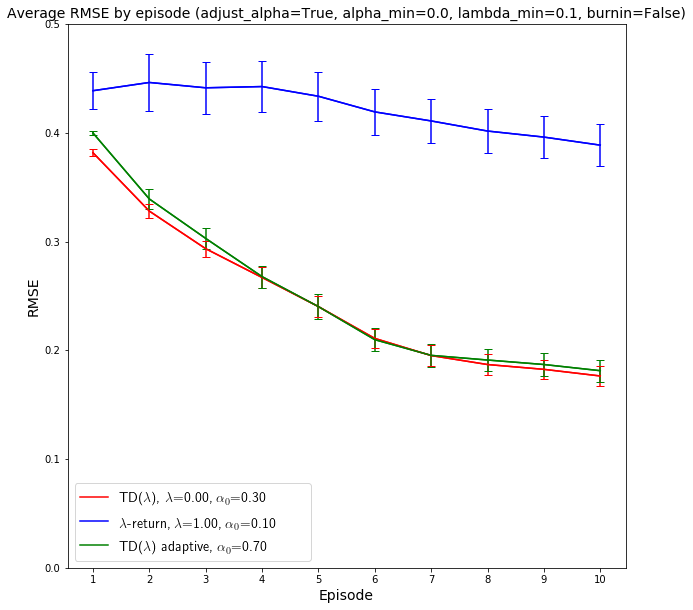

In [13]:
plot_rmse_by_episode(df_rmse_by_episode_td_epi10['rmse_mean'], df_rmse_by_episode_td_epi10['rmse_se'], color="red", max_rmse=0.5, fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_mc_epi10['rmse_mean'], df_rmse_by_episode_mc_epi10['rmse_se'], color="blue", max_rmse=0.5, hold=True, fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_td_adap_epi10['rmse_mean'], df_rmse_by_episode_td_adap_epi10['rmse_se'], color="green", max_rmse=0.5, hold=True,
                     subtitle="(adjust_alpha={}, alpha_min={}, lambda_min={}, burnin={})".format(adjust_alpha, alpha_min, lambda_min, burnin), fontsize=fontsize)
plt.legend([r'TD($\lambda$), $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['td'], alphas_opt['td']),
            r'$\lambda$-return, $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['mc'], alphas_opt['mc']),
            r'TD($\lambda$) adaptive, $\alpha_0$={:.2f}'.format(alphas_opt['td_adap'])], fontsize=fontsize)
plt.savefig("{}/{}-v{}-adjust_alpha={},alpha_min={},lambda_min={},burnin={}-Episodes10.png" \
            .format(g_dir_results, g_prefix, version, adjust_alpha, alpha_min, lambda_min, burnin))

We observe that the RMSE in the $\lambda$-adaptive TD case decreases more slowly than the other two cases, but attains a smaller RMSE value at the end of the 10 episodes, with the important advantage that there is no need of defining hyperparameter $\lambda$.

In addition, the variability observed in the RMSE at each episode tends to be smaller.

#### What happens if we run each experiment for a longer number of episodes?

We now increase the number of episodes run per experiment beyond 10.

In [16]:
# Simulation parameters
seed = 1713
nexperiments = 5
nepisodes = 5000

In [17]:
lambdas_opt = {'td': 0, 'mc': 1, 'td_adap': 0}
alphas_opt = {'td': 0.8, 'mc': 0.1, 'td_adap': 0.7}
#lambdas_opt = {'td': 1, 'mc': 1, 'td_adap': 0.}
#alphas_opt = {'td': 0.01, 'mc': 0.1, 'td_adap': 0.7}

params = dict()
method = 'mc'
params['nexperiments'] = nexperiments
params['nepisodes'] = nepisodes
params['adjust_alpha'] = True
params['adjust_alpha_by_episode'] = False
params['alpha_min'] = 0 #alphas_opt[method] / 100
params['lambda_min'] = 0.1
params['burnin'] = False

version = "0.8"
fontsize = 14

In [9]:
# TD(lambda)
df_results_td, df_rmse_by_episode_td, state_info_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td']], lambdas=[lambdas_opt['td']], gamma=gamma,
                         adjust_alpha=params['adjust_alpha'], adjust_alpha_by_episode=params['adjust_alpha_by_episode'], alpha_min=params['alpha_min'],
                         plot=False, verbose=True, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda)")
print(df_rmse_by_episode_td)
print("visits: {}, alphas_at_episode_end: {}".format(state_info_td['nvisits'], state_info_td['alphas_at_episode_end']))

Parameter set 1 of 1: lambda = 0.00, alpha = 0.80 ---> Running experiment 1 of 5 (#episodes = 1000)... Value function at start of experiment: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Episode 1 of 1000 running...
Episode 101 of 1000 running...
Episode 201 of 1000 running...
Episode 301 of 1000 running...
Episode 401 of 1000 running...
Episode 501 of 1000 running...
Episode 601 of 1000 running...
Episode 701 of 1000 running...
Episode 801 of 1000 running...
Episode 901 of 1000 running...
	RMSE(at end of experiment) = 0.156
Running experiment 2 of 5 (#episodes = 1000)... Value function at start of experiment: [ 0.         -0.96956499 -0.92819089 -0.87917871 -0.81599141 -0.74053303
 -0.65182231 -0.55346302 -0.44534553 -0.33304869 -0.20778889 -0.07815771
  0.05865548  0.20251011  0.33969197  0.48600189  0.60773824  0.7305114
  0.83523868  0.92822979  0.        ]
Episode 1 of 1000 running...
Episode 101 of 1000 running...
Episode 201 of 1000 running...
Episode 301 of 

In [13]:
method = "td"
save(df_rmse_by_episode_td, version, method, "rmse", params, lambdas_opt[method], alphas_opt[method])
save(pd.DataFrame.from_items([('episode', df_rmse_by_episode_td['episode']), ('alpha', state_info_td['alphas_by_episode'])]),
     version, method, "alphas", params, lambdas_opt[method], alphas_opt[method])

Saving data frame to file ./results/SimulateTDLambda_v0.8_td_RMSEByEpisode_l=0.00,a=0.80,adj=True,adjbyepi=False,amin=0_Epi1000_Exp5.csv...
Saving data frame to file ./results/SimulateTDLambda_v0.8_td_AlphasByEpisodeLastExp_l=0.00,a=0.80,adj=True,adjbyepi=False,amin=0_Epi1000_Exp5.csv...


,episode,alpha
0,1,0.800000
1,2,0.800000
2,3,0.800000
3,4,0.800000
4,5,0.800000
5,6,0.800000
6,7,0.800000
7,8,0.800000
8,9,0.800000
9,10,0.800000


In [18]:
# lambda-return
df_results_mc, df_rmse_by_episode_mc, state_info_mc = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['mc']], lambdas=[lambdas_opt['mc']], gamma=gamma,
                         adjust_alpha=params['adjust_alpha'], adjust_alpha_by_episode=params['adjust_alpha_by_episode'], alpha_min=params['alpha_min'],
                         plot=False, verbose=True, debug=False, show_warnings=False)
print("RMSE by Episode for MC(lambda)")
print(df_rmse_by_episode_mc)
print("visits: {}, alphas_at_episode_end: {}".format(state_info_mc['nvisits'], state_info_mc['alphas_at_episode_end']))

Parameter set 1 of 1: lambda = 1.00, alpha = 0.10 ---> Running experiment 1 of 5 (#episodes = 5000)... Value function at start of experiment: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Episode 1 of 5000 running...
Episode 101 of 5000 running...
Episode 201 of 5000 running...
Episode 301 of 5000 running...
Episode 401 of 5000 running...
Episode 501 of 5000 running...
Episode 601 of 5000 running...
Episode 701 of 5000 running...
Episode 801 of 5000 running...
Episode 901 of 5000 running...
Episode 1001 of 5000 running...
Episode 1101 of 5000 running...
Episode 1201 of 5000 running...
Episode 1301 of 5000 running...
Episode 1401 of 5000 running...
Episode 1501 of 5000 running...
Episode 1601 of 5000 running...
Episode 1701 of 5000 running...
Episode 1801 of 5000 running...
Episode 1901 of 5000 running...
Episode 2001 of 5000 running...
Episode 2101 of 5000 running...
Episode 2201 of 5000 running...
Episode 2301 of 5000 running...
Episode 2401 of 5000 running...
Episo

In [19]:
method = "mc"
save(df_rmse_by_episode_mc, version, method, "rmse", params, lambdas_opt[method], alphas_opt[method])
save(pd.DataFrame.from_items([('episode', df_rmse_by_episode_mc['episode']), ('alpha', state_info_mc['alphas_by_episode'])]),
     version, method, "alphas", params, lambdas_opt[method], alphas_opt[method])

Saving data frame to file ./results/SimulateTDLambda_v0.8_mc_RMSEByEpisode_l=1.00,a=0.10,adj=True,adjbyepi=False,amin=0_Epi5000_Exp5.csv...
Saving data frame to file ./results/SimulateTDLambda_v0.8_mc_AlphasByEpisodeLastExp_l=1.00,a=0.10,adj=True,adjbyepi=False,amin=0_Epi5000_Exp5.csv...


,episode,alpha
0,1,0.100000
1,2,0.100000
2,3,0.100000
3,4,0.100000
4,5,0.100000
5,6,0.100000
6,7,0.100000
7,8,0.100000
8,9,0.100000
9,10,0.100000


In [110]:
# Adaptive TD(lambda)
df_results_td_adap, df_rmse_by_episode_td_adap, state_info_td_adap = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td_adap']], lambdas=[lambdas_opt['td_adap']], gamma=gamma,
                         adjust_alpha=params['adjust_alpha'], adjust_alpha_by_episode=params['adjust_alpha_by_episode'], alpha_min=params['alpha_min'],
                         lambda_min=lambda_min, burnin=burnin,
                         plot=False, verbose=True, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda) adaptive")
print(df_rmse_by_episode_td_adap)
print("visits: {}, alphas_at_episode_end: {}".format(state_info_td['nvisits'], state_info_td['alphas_at_episode_end']))

RMSE by Episode for TD(lambda) adaptive
     episode  rmse_mean   rmse_se
0          1   0.405359  0.003854
1          2   0.341274  0.020874
2          3   0.291335  0.012849
3          4   0.247422  0.013137
4          5   0.238767  0.036120
5          6   0.174117  0.032959
6          7   0.133151  0.031371
7          8   0.160277  0.027587
8          9   0.140357  0.029936
9         10   0.151429  0.041604
10        11   0.139695  0.034589
11        12   0.136365  0.032312
12        13   0.134030  0.033697
13        14   0.130383  0.036161
14        15   0.130486  0.032102
15        16   0.131730  0.032266
16        17   0.131952  0.032361
17        18   0.127287  0.028150
18        19   0.126591  0.026761
19        20   0.127613  0.027852
20        21   0.123583  0.028661
21        22   0.120978  0.027687
22        23   0.120216  0.027776
23        24   0.114803  0.027663
24        25   0.114604  0.027485
25        26   0.108558  0.027220
26        27   0.110359  0.027371
27      

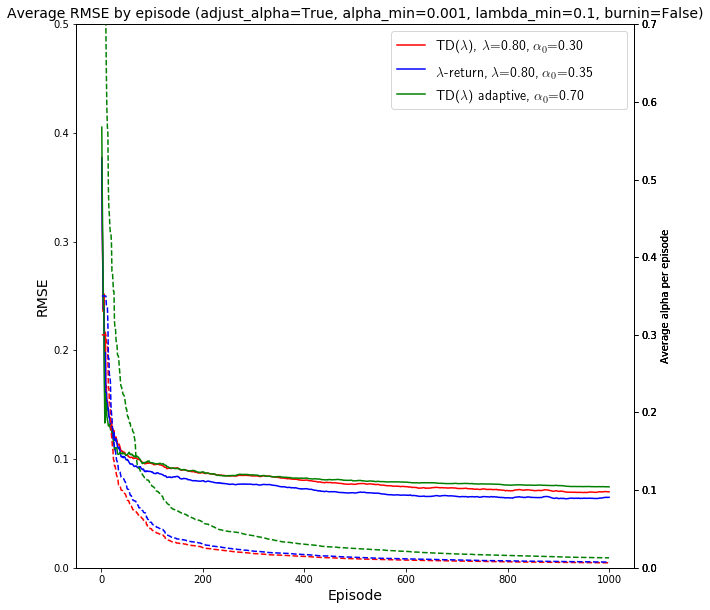

In [112]:
max_alpha = np.max(list(alphas_opt.values()))
plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], None, #df_rmse_by_episode_td['rmse_se'],
                     max_rmse=0.5, color="red",
                     alphas=state_info_td['alphas_by_episode'], max_alpha=max_alpha, marker_alphas='r--', fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], None, #df_rmse_by_episode_mc['rmse_se'],
                     max_rmse=0.5, color="blue", hold=True,
                     alphas=state_info_mc['alphas_by_episode'], max_alpha=max_alpha, marker_alphas='b--', fontsize=fontsize)
plot_rmse_by_episode(df_rmse_by_episode_td_adap['rmse_mean'], None, #df_rmse_by_episode_td_adap['rmse_se'],
                     max_rmse=0.5, color="green", hold=True,
                     subtitle="(adjust_alpha={}, alpha_min={}, lambda_min={}, burnin={})".format(adjust_alpha, alpha_min, lambda_min, burnin),
                     alphas=state_info_adap['alphas_by_episode'], max_alpha=max_alpha, marker_alphas='g--', fontsize=fontsize)
plt.legend([r'TD($\lambda$), $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['td'], alphas_opt['td']),
            r'$\lambda$-return, $\lambda$={:.2f}, $\alpha_0$={:.2f}'.format(lambdas_opt['mc'], alphas_opt['mc']),
            r'TD($\lambda$) adaptive, $\alpha_0$={:.2f}'.format(alphas_opt['td_adap'])], fontsize=fontsize)
plt.savefig("{}/{}-v{}-td{}-lr{},tdadap{},adjust_alpha={},alpha_min={},lambda_min={}-Episodes{}.png" \
            .format(g_dir_results, g_prefix, version, lambdas_opt['td'], lambdas_opt['mc'], alphas_opt['td_adap'], adjust_alpha, alpha_min, lambda_min, nepisodes))

## Temporal Difference

We observe that the RMSE starts increasing back in all cases, and that the $\lambda$-adaptive TD method attains a larger RMSE value than the other two methods.

This is most likely due to the fact that **the $\alpha$ parameter is not decreased with time**, as required for convergence.

This is the next thing to try, namely, to decrease $\alpha$ appropriately with time.

In [49]:
# Load saved data to plot
params['adjust_alpha_by_episode'] = False
params['alpha_min'] = 0
params['nepisodes'] = 100

method = "td"
df_rmse_by_episode_td = load(method, "rmse", params, lambdas_opt[method], alphas_opt[method])
alphas_td = load(method, "alphas", params, lambdas_opt[method], alphas_opt[method])
state_info_td['alphas_by_episode'] = alphas_td['alpha']

Reading data into data frame from file ./results/SimulateTDLambda_td_RMSEByEpisode_l=0.00,a=0.80,adj=True,adjbyepi=False,amin=0_Epi100_Exp5.csv...
Reading data into data frame from file ./results/SimulateTDLambda_td_AlphasByEpisodeLastExp_l=0.00,a=0.80,adj=True,adjbyepi=False,amin=0_Epi100_Exp5.csv...


### a) Adjustment by STATE COUNT

The values of $\alpha$ plotted by episode in this case are averages across all the states *visited in the episode* and are shown only for the last experiment.

Their values oscilate considerably because the states visited in one episode may be quite different from the states visited in the previous episode.

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


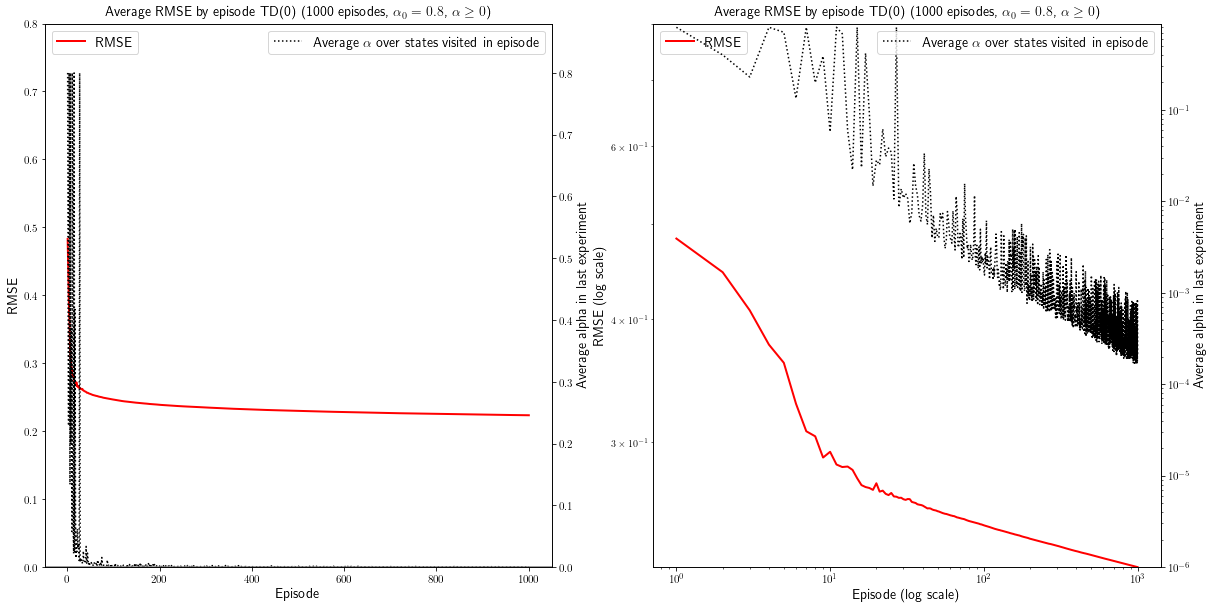

In [187]:
# TD(0)
# Adjust alpha by count: alpha_min = 0
# Experiments = 5
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


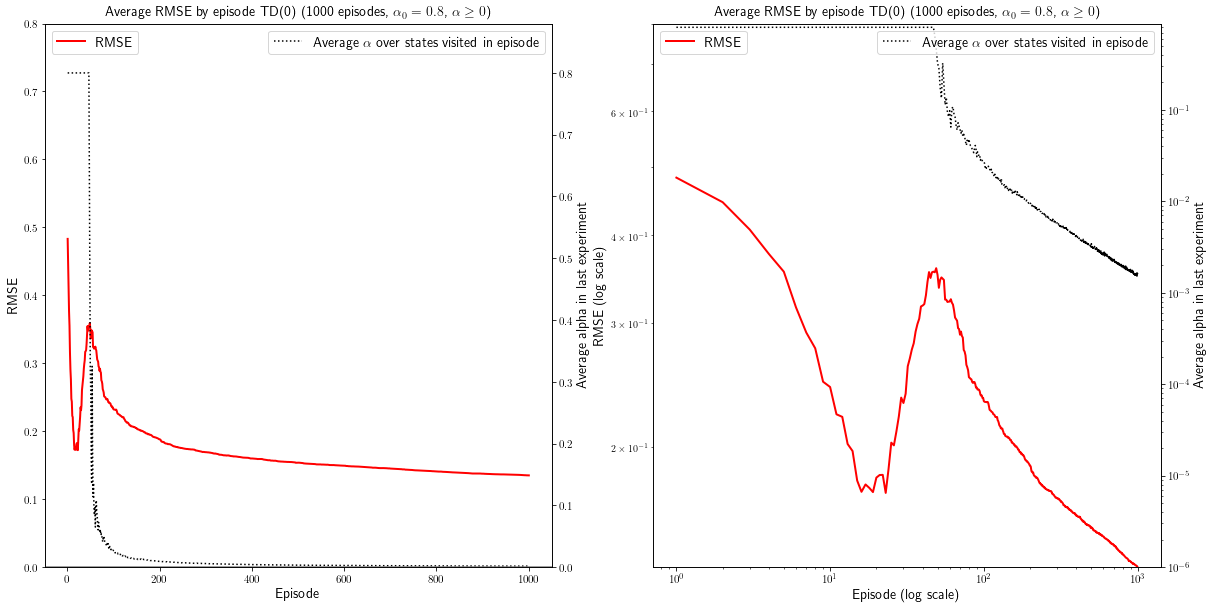

In [14]:
# TD(0)
# Adjust alpha by count: alpha_min = 0
# FIRST-VISIT adjustment of alpha
# Experiments = 5
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)


C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


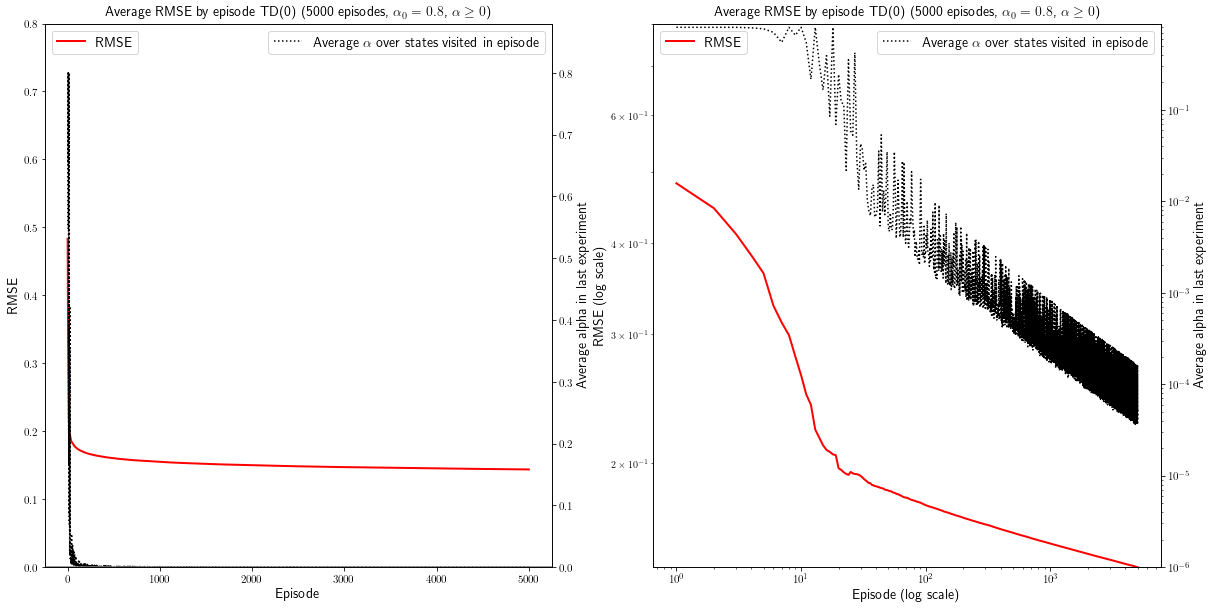

In [185]:
# TD(0)
# Adjust alpha by count: alpha_min = 0
# 5000 episodes
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

**OBSERVATION:** We observe that the plotted RMSE at episode 1000 is not the same as the RMSE shown in the previous plot that runs up to 1000 episodes!!

The reason is that, *when we run more than one experiment*, the random number generator for the second experiment is at a different state when we run 5000 episodes on the first experiment compared to the state it is when we run just 1000 episodes...

But the remarkable thing is rather that the average RMSE observed in the 5000-long simulation is *significantly smaller* at episode 1000 than the average RMSE observed at the end of the 1000-long simulation! This says a lot about the variability generated by the $\alpha$ decreasing as the inverse of the state occupation count: since the trajectories are different in the 5000-long simulation compared to the 1000-long simulation (as just explained), the $\alpha$ values used in the 5000-long experiments may be very different from the values used in the 1000-long experiments.

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


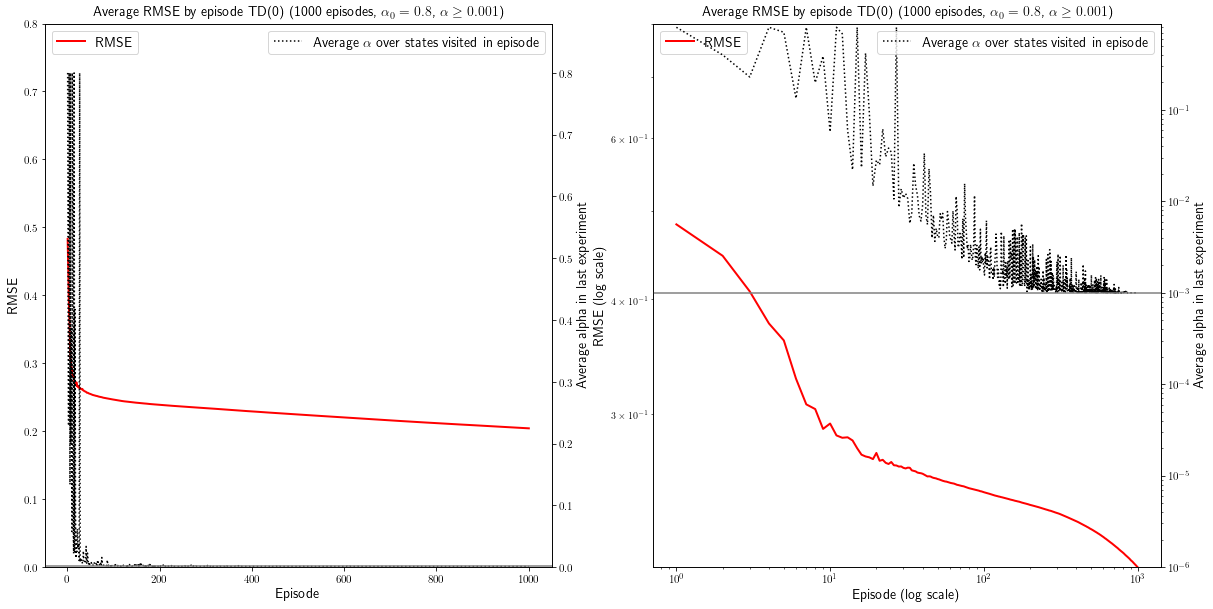

In [137]:
# TD(0)
# Adjust alpha by count: alpha_min = 0.001
# Experiments = 5
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


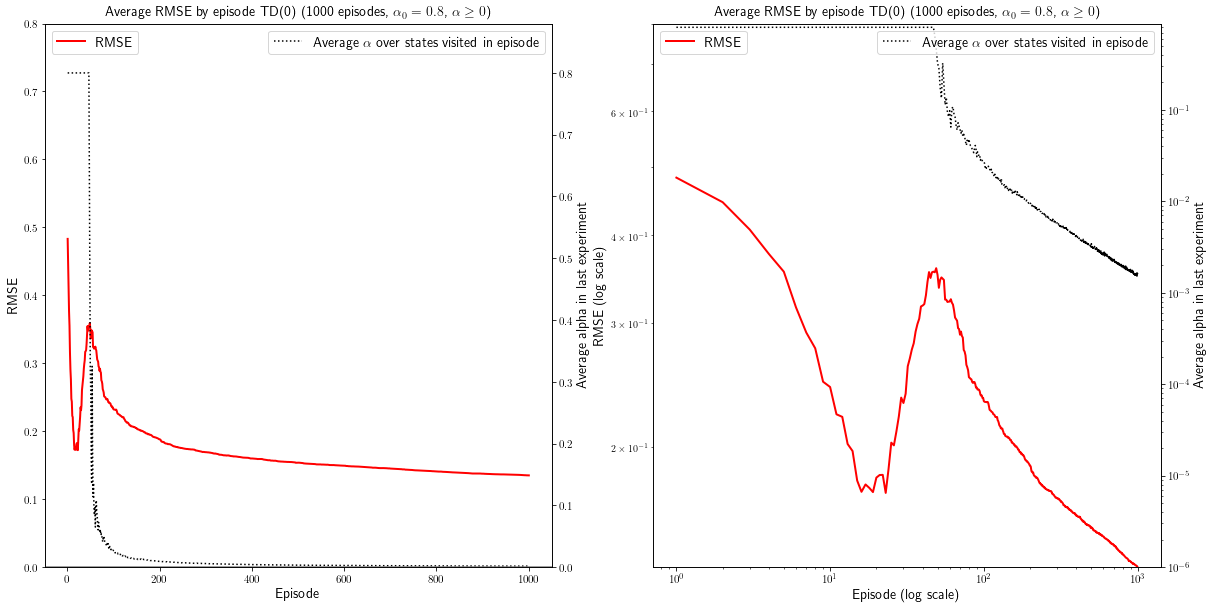

In [15]:
# TD(0)
# Adjust alpha by count: alpha_min = 0.008
# Experiments = 5
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


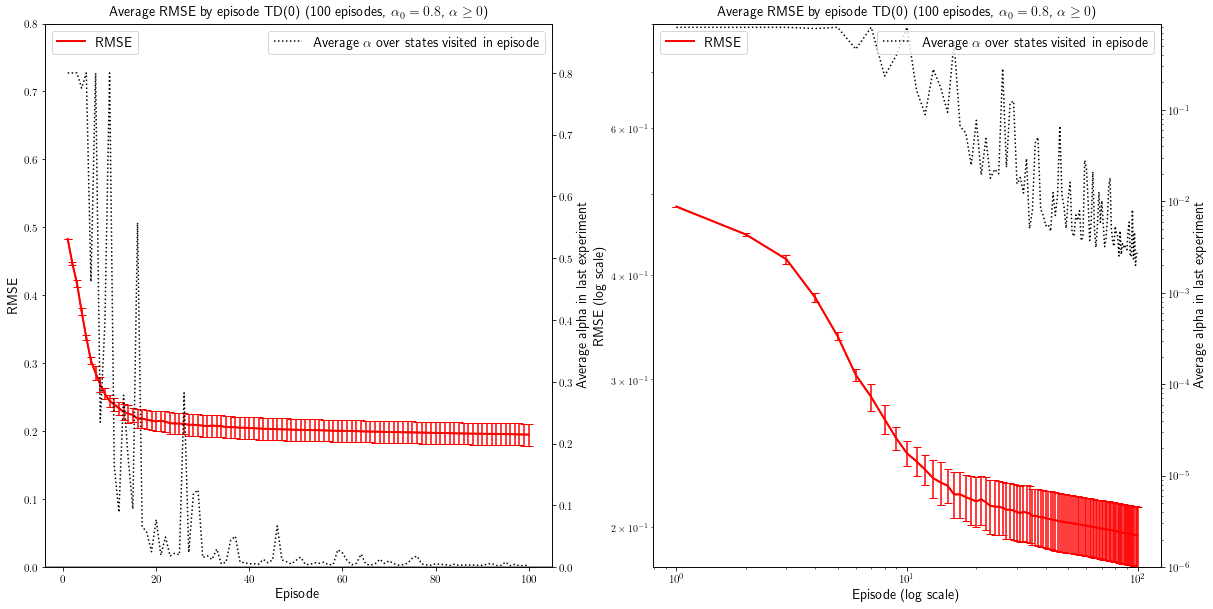

In [44]:
# TD(0)
# Adjust alpha by count: alpha_min = 0
# Experiments = 5
# 100 episodes with error bars
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], df_rmse_by_episode_td['rmse_se'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

### b) Adjustment by EPISODE

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


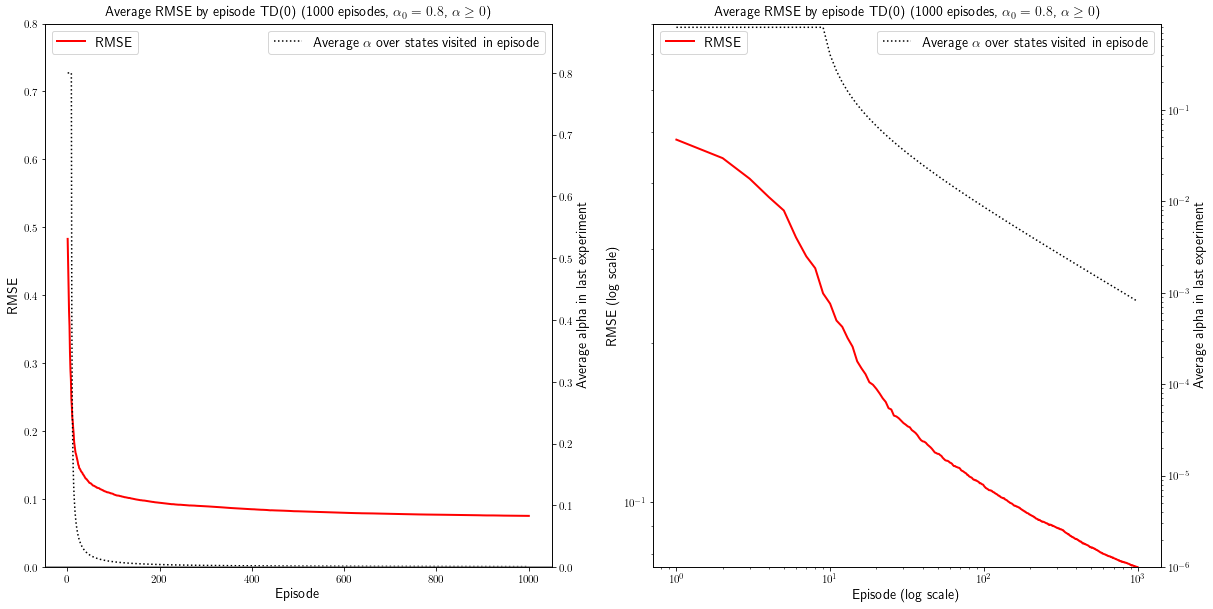

In [139]:
# TD(0)
# Adjust alpha by EPISODE: alpha_min = 0
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


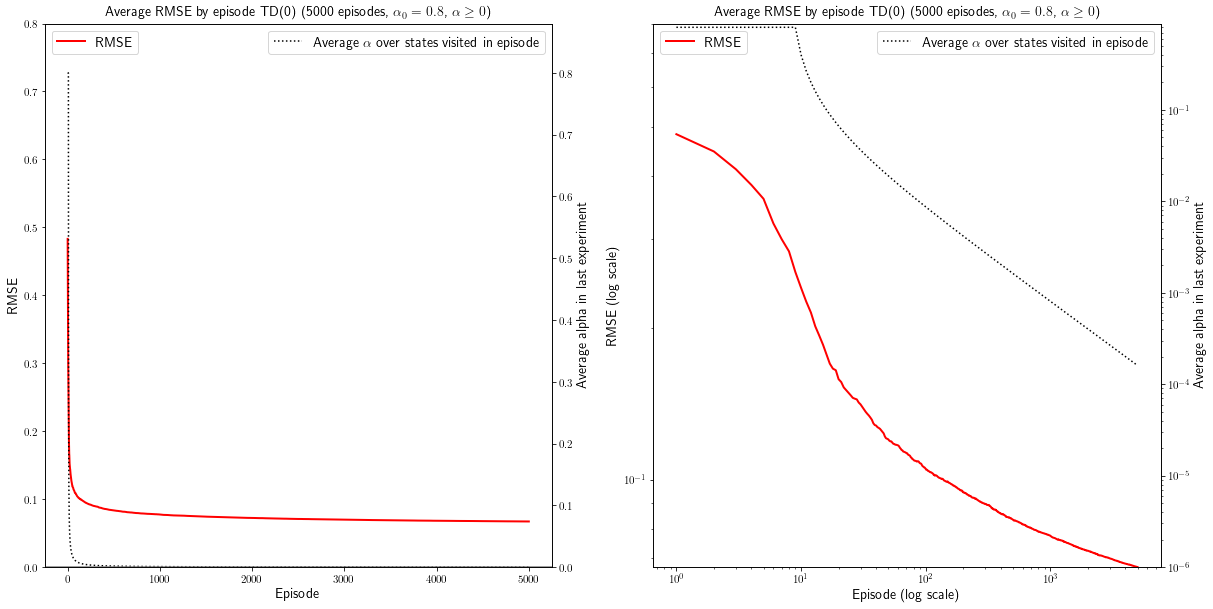

In [182]:
# TD(0)
# Adjust alpha by EPISODE: alpha_min = 0
# 5000 episodes
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


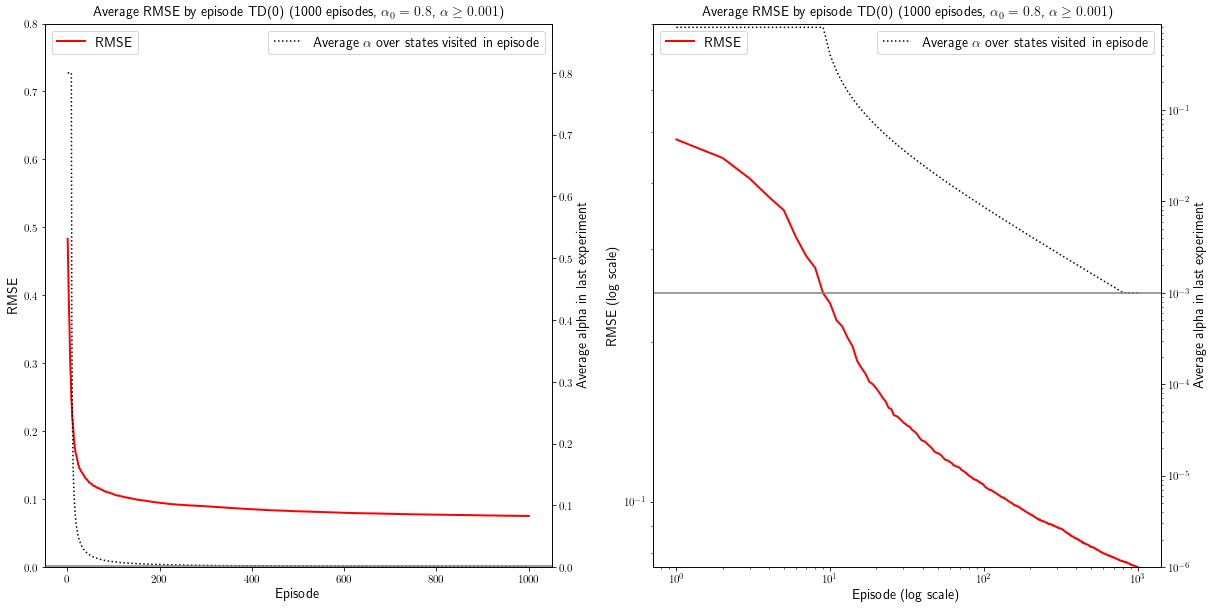

In [141]:
# TD(0)
# Adjust alpha by EPISODE: alpha_min = 0.001 --> This value is not enough for fast enough learning.
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


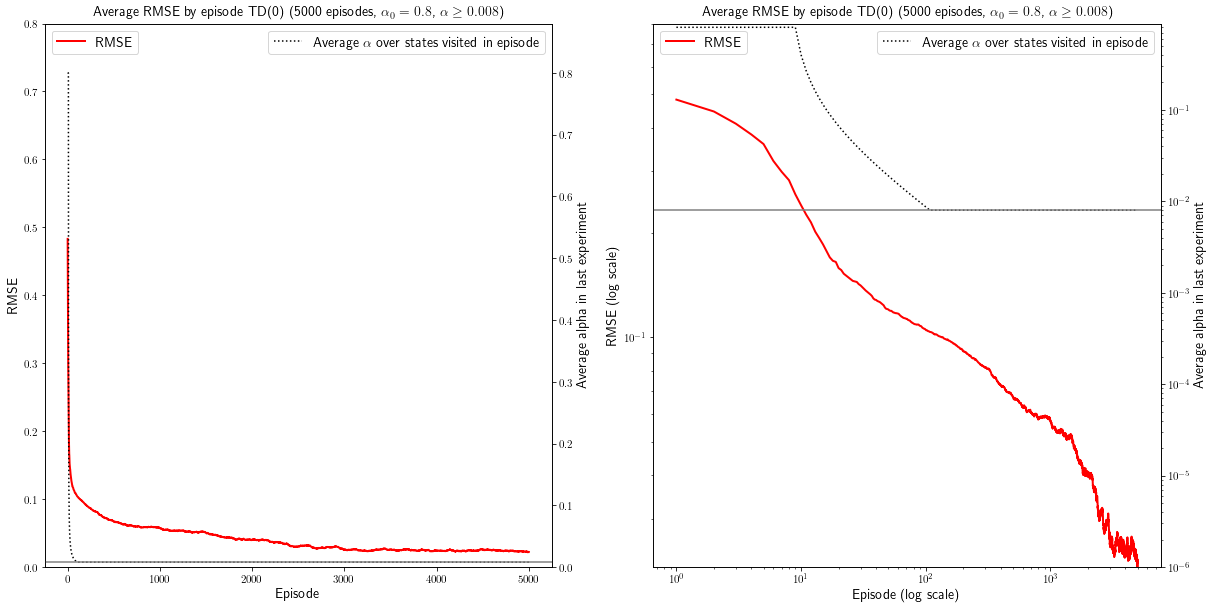

In [178]:
# TD(0)
# Adjust alpha by EPISODE: alpha_min = 0.008
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


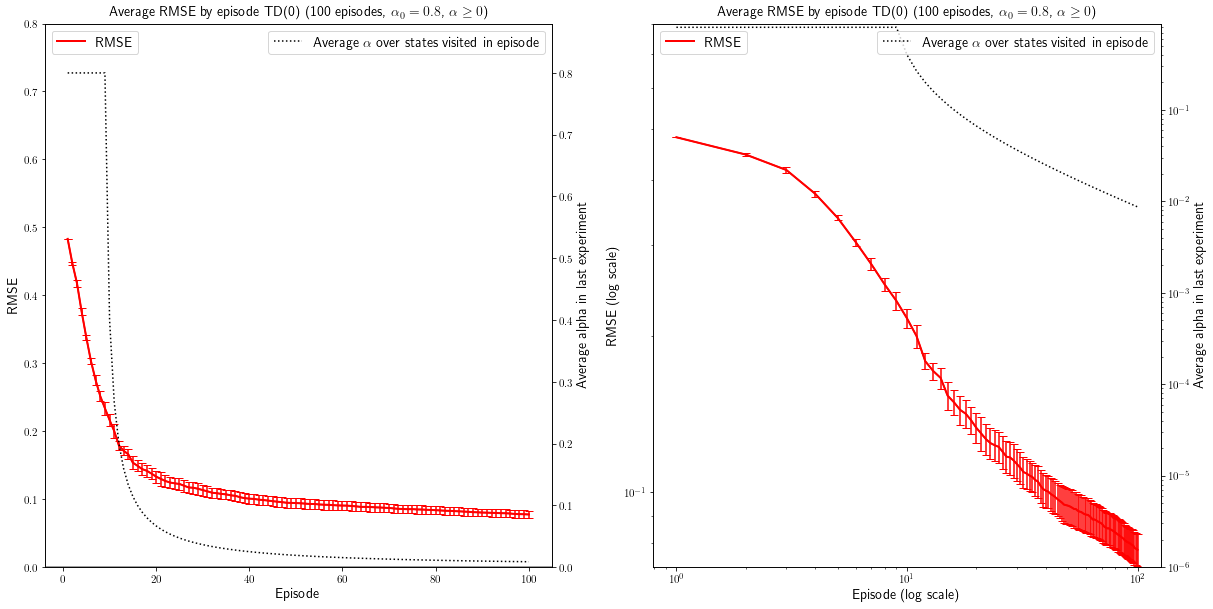

In [38]:
# TD(0)
# Adjust alpha by count: alpha_min = 0
# Experiments = 5
# 100 episodes with error bars
method = "td"
subtitle = r"TD({}) ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(lambdas_opt[method], params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], df_rmse_by_episode_td['rmse_se'], max_rmse=0.8,
                                                  alphas=state_info_td['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="red", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method + str(lambdas_opt[method]), params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

## Monte Carlo

In [179]:
# Load saved data to plot
params['adjust_alpha_by_episode'] = True
params['alpha_min'] = 0

method = "mc"
df_rmse_by_episode_mc = load(method, "rmse", params, lambdas_opt[method], alphas_opt[method])
alphas_mc = load(method, "alphas", params, lambdas_opt[method], alphas_opt[method])
state_info_mc['alphas_by_episode'] = alphas_mc['alpha']

Reading data into data frame from file ./results/SimulateTDLambda_mc_RMSEByEpisode_l=1.00,a=0.10,adj=True,adjbyepi=True,amin=0_Epi5000_Exp5.csv...
Reading data into data frame from file ./results/SimulateTDLambda_mc_AlphasByEpisodeLastExp_l=1.00,a=0.10,adj=True,adjbyepi=True,amin=0_Epi5000_Exp5.csv...


### a) Adjustment by STATE COUNT

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


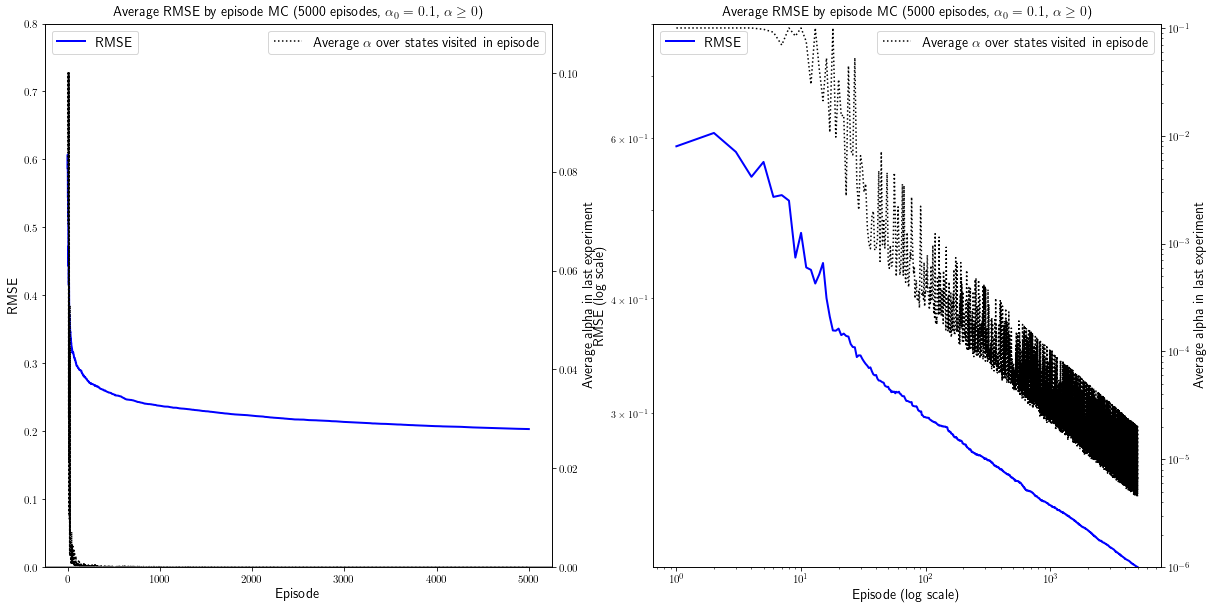

In [164]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Experiments = 5
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


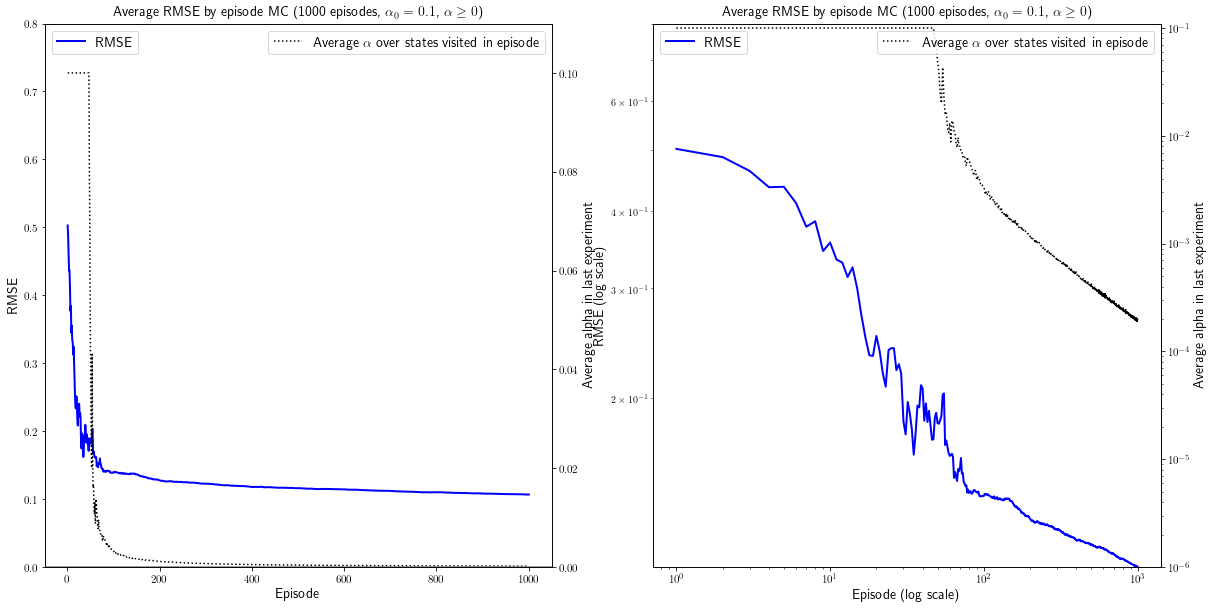

In [27]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Experiments = 5
# FIRST-VISIT UPDATE OF VALUE FUNCTION
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


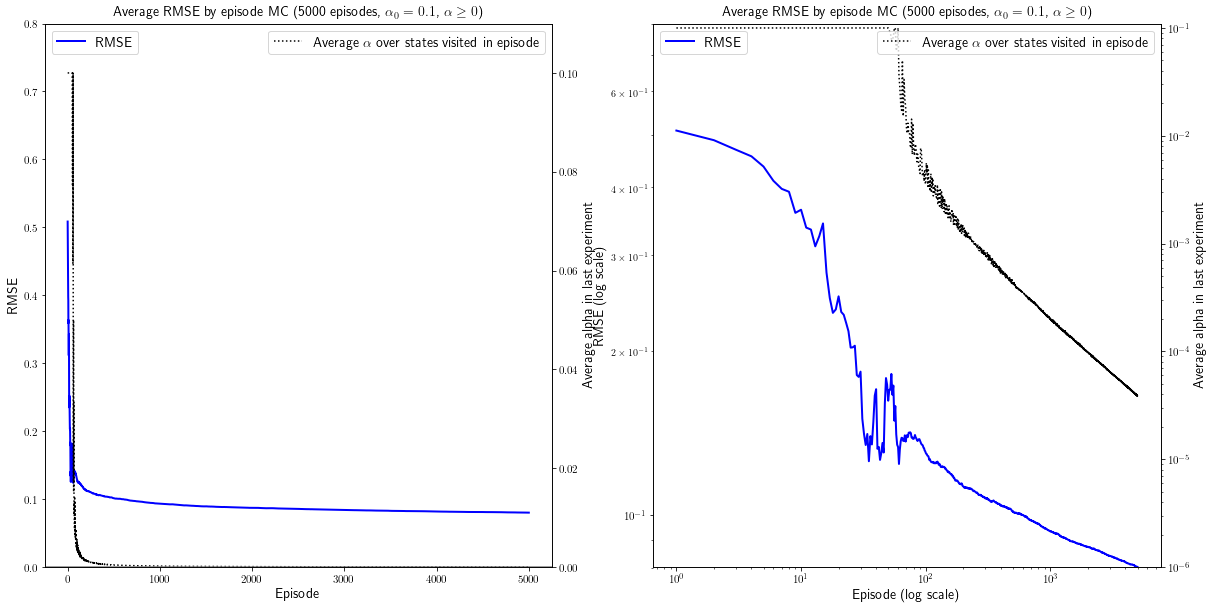

In [20]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Experiments = 5
# FIRST-VISIT UPDATE OF VALUE FUNCTION
# 5000 episodes
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


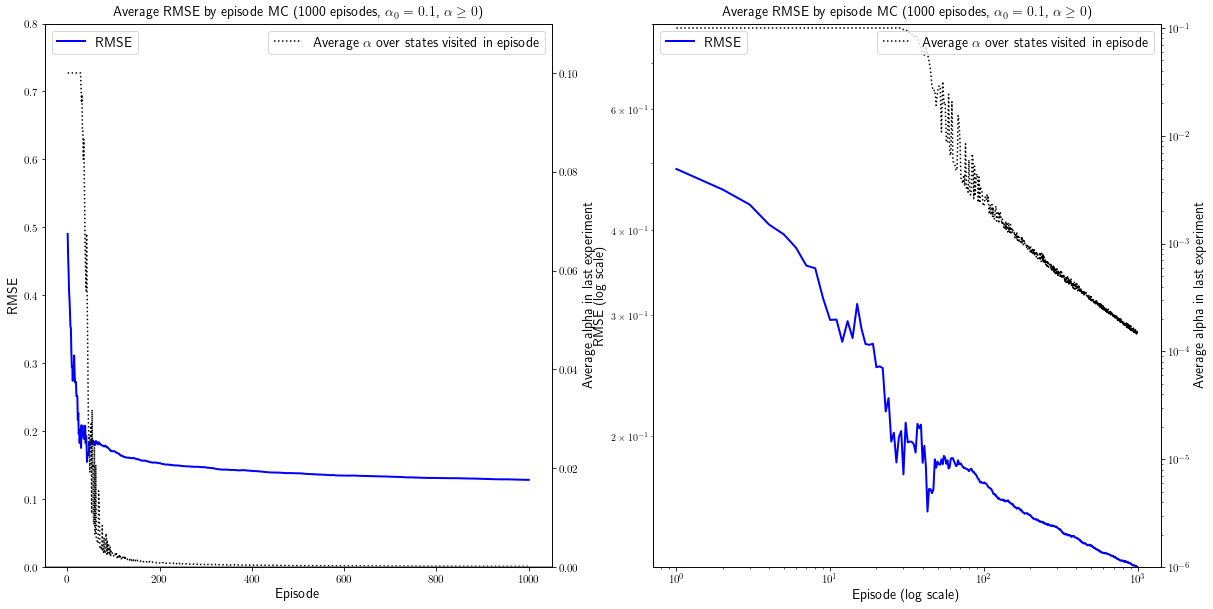

In [15]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Experiments = 5, start=10 (always)
# FIRST-VISIT UPDATE OF VALUE FUNCTION
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


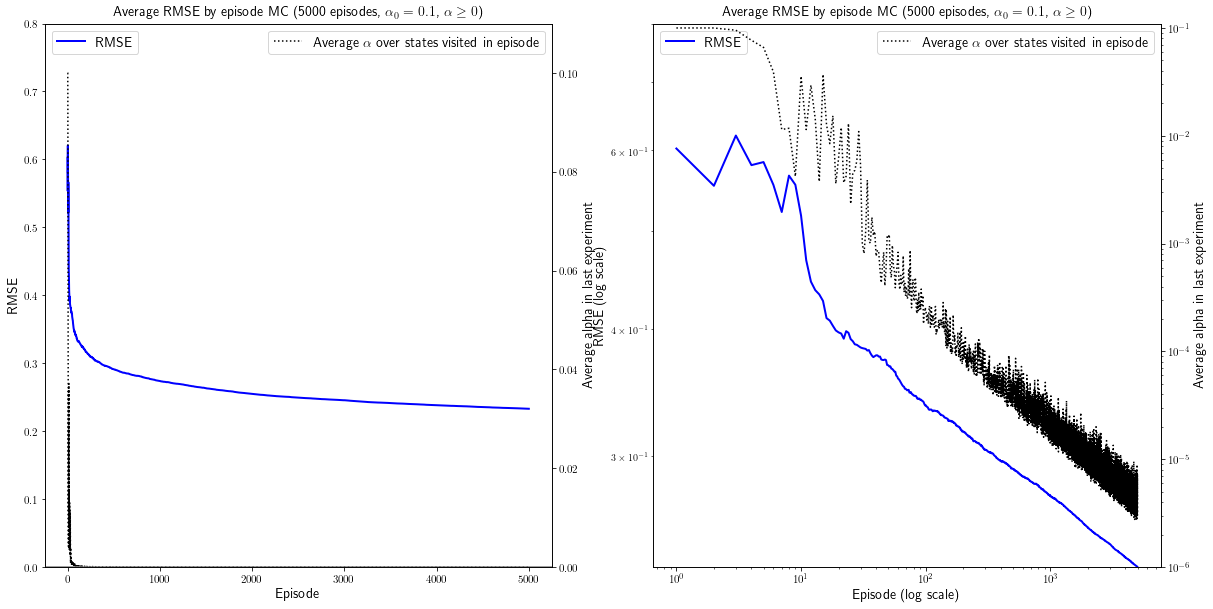

In [25]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Start ALWAYS at state = 10 ==> CONVERGENCE IS EVEN SLOWER THAN WITH RANDOM START! (results not saved -nor data, nor plot)
# Experiments = 5
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


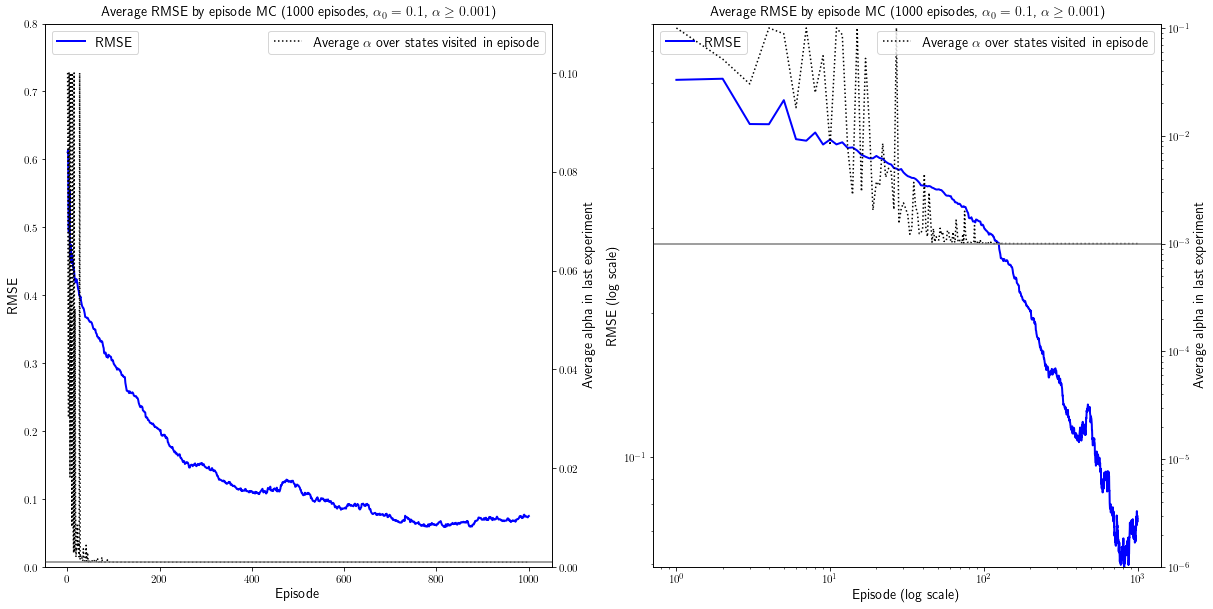

In [146]:
# MC
# Alpha adjusted by count: alpha_min = 0.001
# Experiments = 5
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


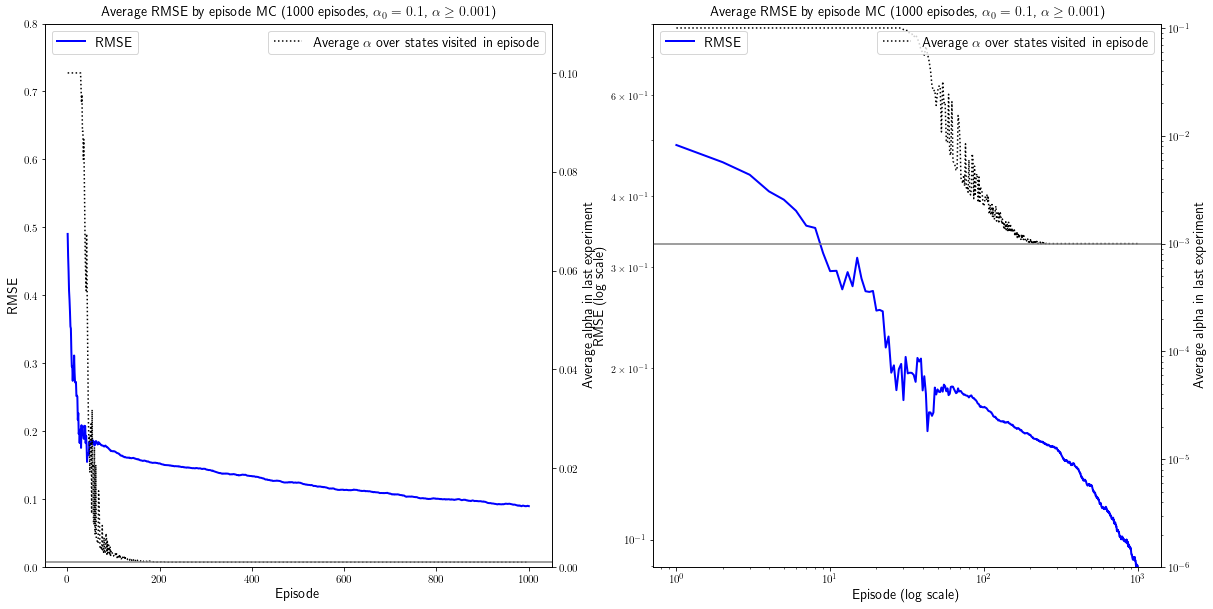

In [19]:
# MC
# Alpha adjusted by count: alpha_min = 0.001
# Experiments = 5, start = 10
# FIRST-VISIT UPDATE
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


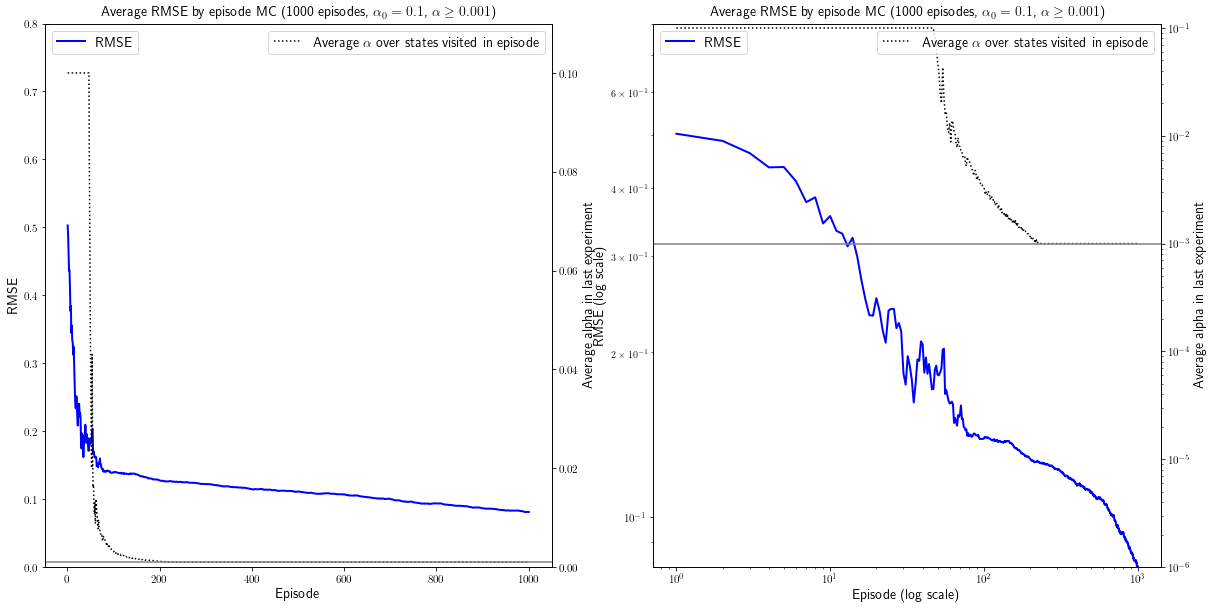

In [23]:
# MC
# Alpha adjusted by count: alpha_min = 0.001
# Experiments = 5
# FIRST-VISIT UPDATE
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


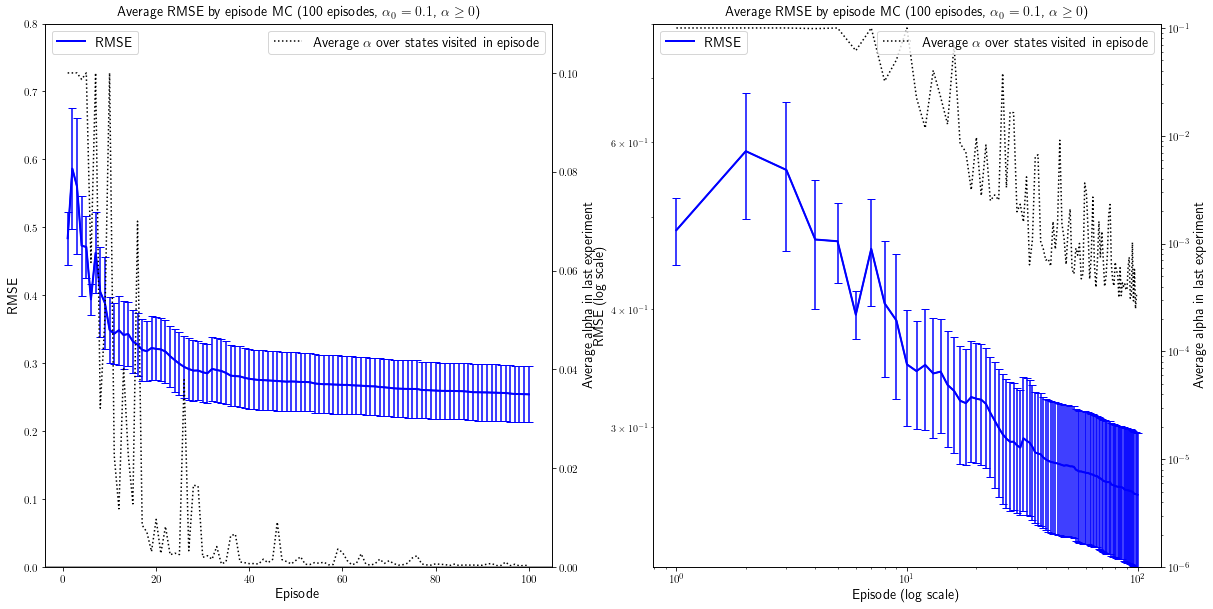

In [56]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Experiments = 5
# 100 episodes with error bars
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], df_rmse_by_episode_mc['rmse_se'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

### b) Adjustment by EPISODE 

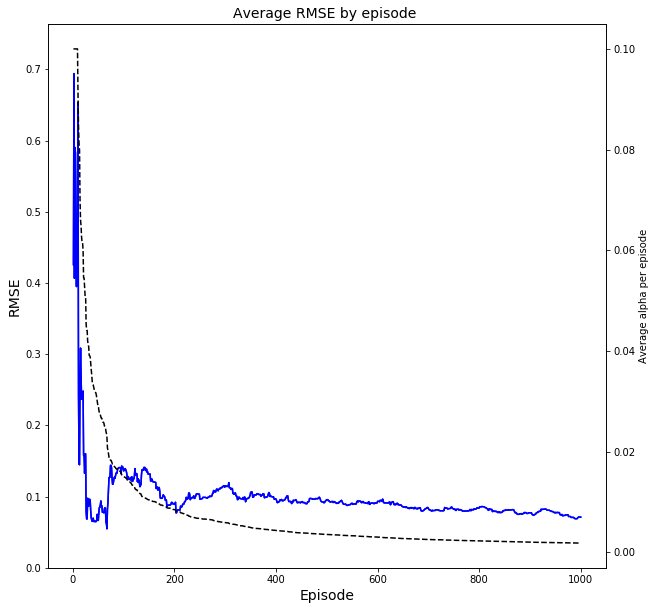

In [51]:
# MC
# Alpha adjusted by EPISODE: alpha_min = 0.0
# 1 Experiment
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                     subtitle=r"MC ({} episodes, $\alpha$ min={})".format(params['nepisodes'], params['alpha_min']), alphas=state_info_mc['alphas_by_episode'],
                     color="blue", fontsize=fontsize, legend=True)

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


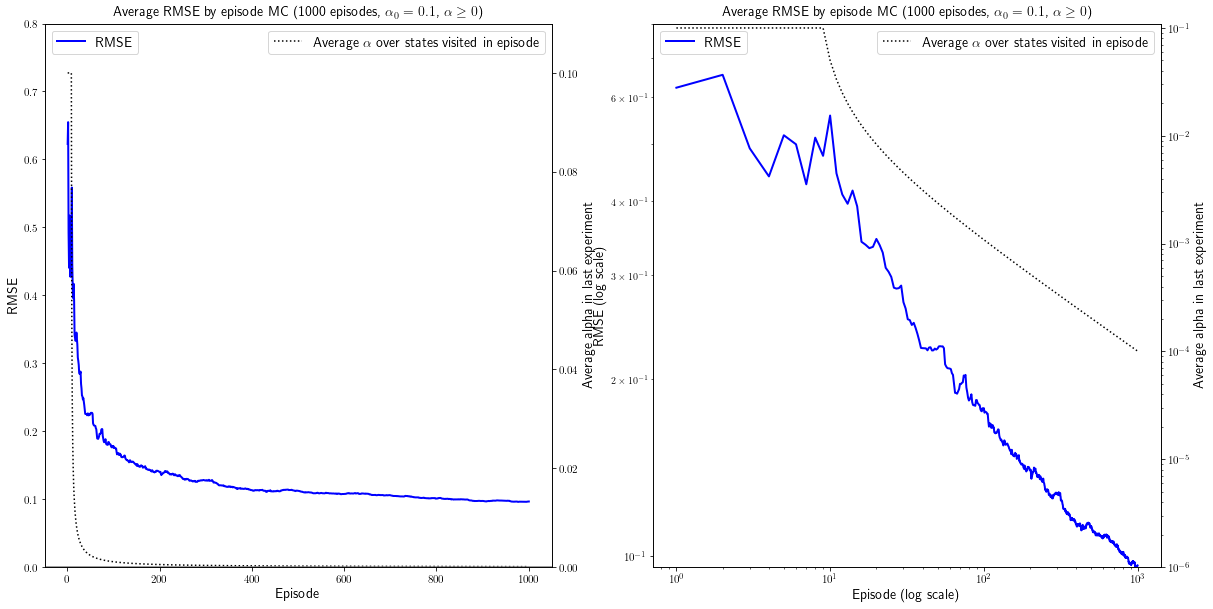

In [154]:
# MC
# Alpha adjusted by EPISODE: alpha_min = 0
# Experiments = 5
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                               alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                               subtitle=subtitle,
                               color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


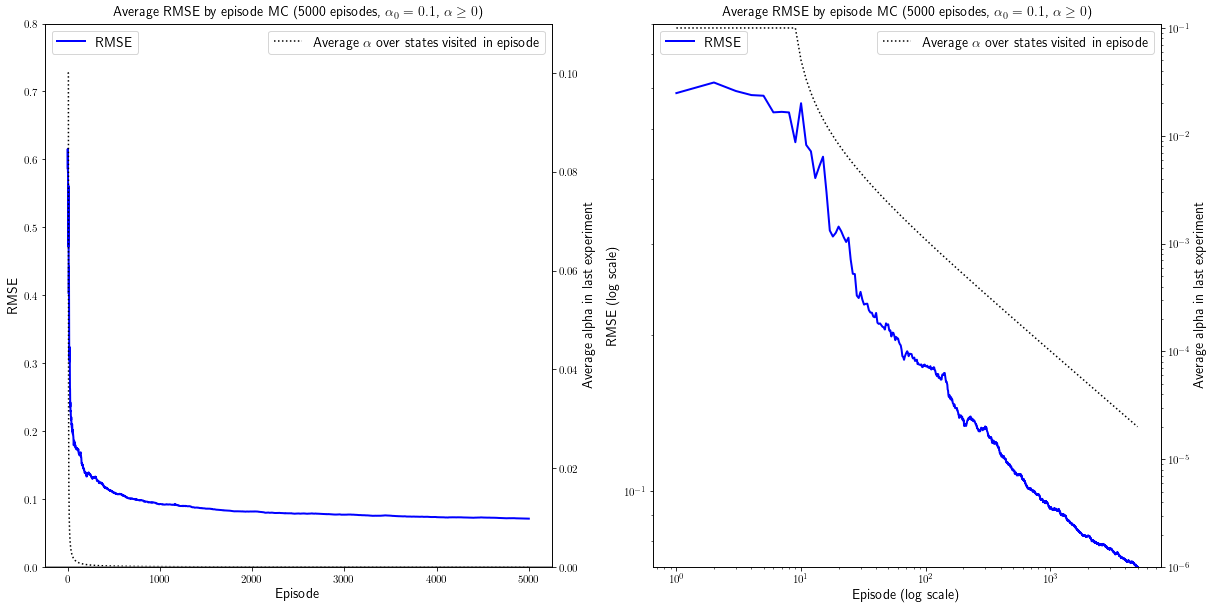

In [180]:
# MC
# Alpha adjusted by EPISODE: alpha_min = 0
# 5000 episodes
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                               alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                               subtitle=subtitle,
                               color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


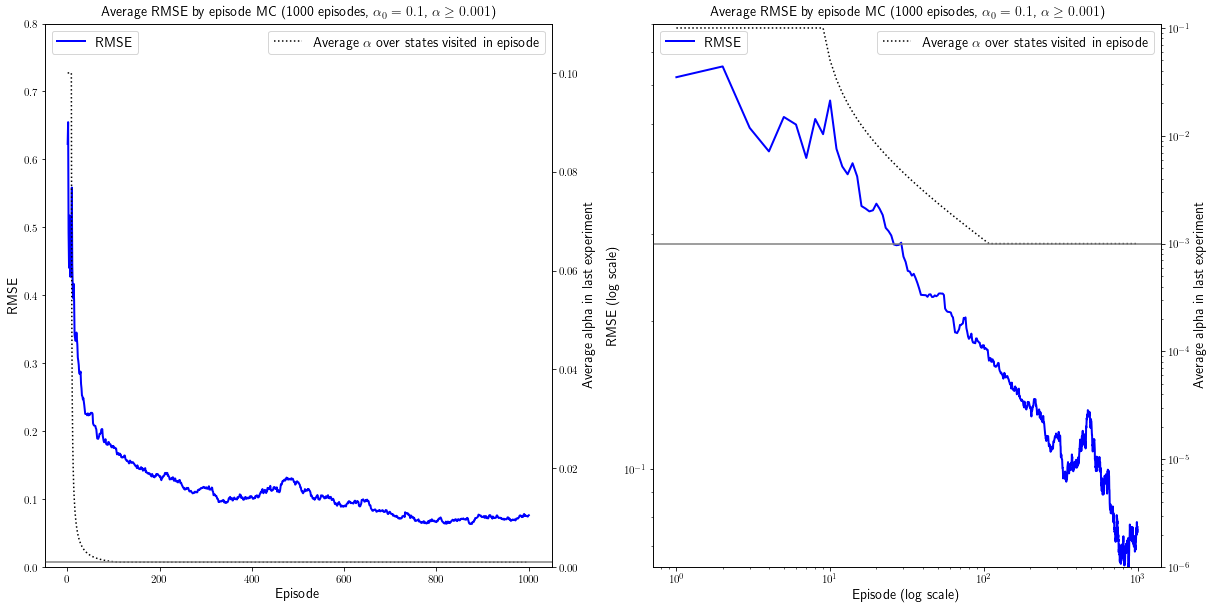

In [156]:
# MC
# Alpha adjusted by EPISODE: alpha_min = 0.001
# Experiments = 5
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


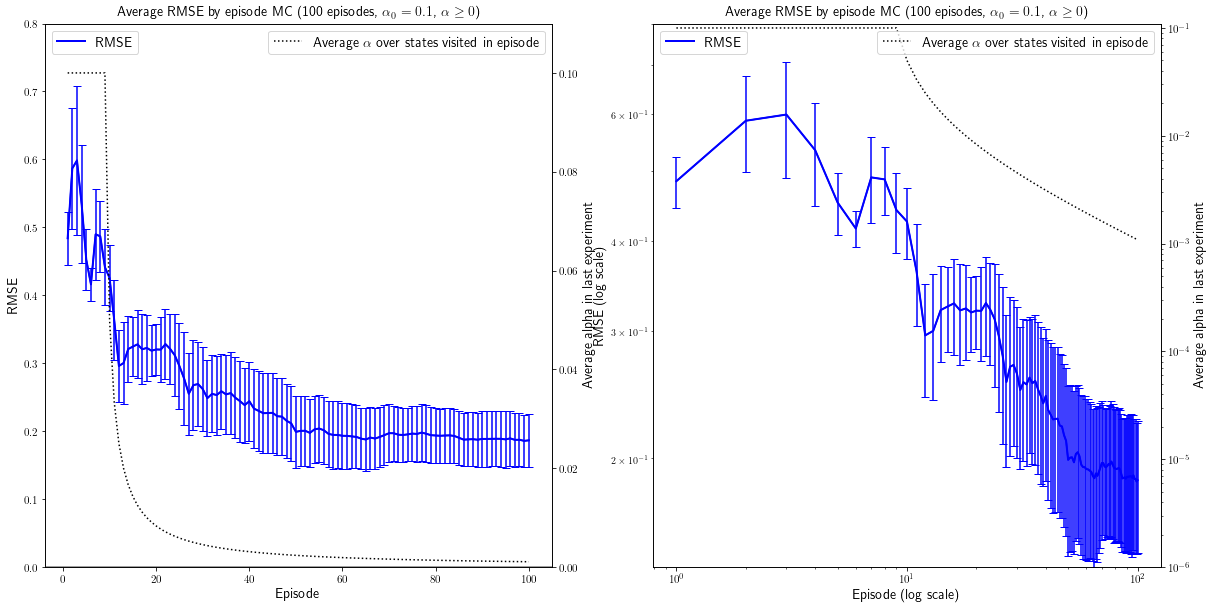

In [60]:
# MC
# Alpha adjusted by count: alpha_min = 0
# Experiments = 5
# 100 episodes with error bars
method = "mc"
subtitle = r"MC ({} episodes, $\alpha_0={}$, $\alpha \geq {}$)".format(params['nepisodes'], alphas_opt[method], params['alpha_min'])
ax, ax_tlog, ax2, ax2_tlog = plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], df_rmse_by_episode_mc['rmse_se'], max_rmse=0.8,
                                                  alphas=state_info_mc['alphas_by_episode'], alpha_min=params['alpha_min'], max_alpha=alphas_opt[method]*1.1,
                                                  subtitle=subtitle,
                                                  color="blue", fontsize=fontsize, legend=True)
plt.savefig("{}/{}-v{}-{}-adjbyepi={},amin={}-Epi{}-Exp{}.png" \
            .format(g_dir_results, g_prefix, version, method, params['adjust_alpha_by_episode'], params['alpha_min'], params['nepisodes'], params['nexperiments']))

In [28]:
globals()['simulate']

<function __main__.simulate>